In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install rasterio
%pip install pytorch_ssim
%pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 96.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch_ssim: filename=pytorch_ssim-0.1-py3-none-any.whl size=2006 sha256=860bcb3a94788ed02b46c35d51292a95a05cc80964f42af69a99d4484a90cfa1
  Stored in directory: /root/.cache/pip/wheels/58/68/a2/68a41e8268a076c128bbc3988d243187fa4681828e648bf1ca
Successfully built pytorch_ssim
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import shutil

# Path to your dataset folder
folder_path = os.path.expanduser("/content/drive/MyDrive/upload")

# Make sure band folders exist
channels = ["VIS", "WV", "TIR1", "TIR2"]
for ch in channels:
    os.makedirs(os.path.join(folder_path, ch), exist_ok=True)

# Loop over all files and move them based on band
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if not os.path.isfile(file_path):
        continue

    # Check if it's a .tif file and has proper format
    if filename.endswith(".tif") and "_IMG_" in filename:
        band = filename.split("_IMG_")[-1].split(".")[0].upper()
        if band in channels:
            dest_dir = os.path.join(folder_path, band)
            shutil.move(file_path, os.path.join(dest_dir, filename))
            print(f"Moved: {filename} → {band}/")


In [ ]:
import os
import rasterio
import matplotlib.pyplot as plt

base_path = '/content/drive/MyDrive/upload'
channel_folders = {
    'vis': 'VIS',
    'wv': 'WV',
    'tir1': 'TIR1',
    'tir2': 'TIR2'
}

In [ ]:
import re

def extract_timestamp(filename):
    match = re.search(r'3RIMG_(\d{2}[A-Z]{3}\d{4})_(\d{4})_L1C', filename)
    if match:
        return f"{match.group(1)}_{match.group(2)}"
    return None

In [ ]:
from collections import defaultdict

channel_timestamps = defaultdict(set)

for ch, folder in channel_folders.items():
    folder_path = os.path.join(base_path, folder)
    for f in os.listdir(folder_path):
        if f.endswith('.tif'):
            ts = extract_timestamp(f)
            if ts:
                channel_timestamps[ch].add(ts)

common_timestamps = set.intersection(*channel_timestamps.values())
common_timestamps = sorted(list(common_timestamps))

print(f"Found {len(common_timestamps)} common timestamps")
print("Example:", common_timestamps[:5])

Found 573 common timestamps
Example: ['01JUN2025_0015', '01JUN2025_0045', '01JUN2025_0115', '01JUN2025_0145', '01JUN2025_0215']


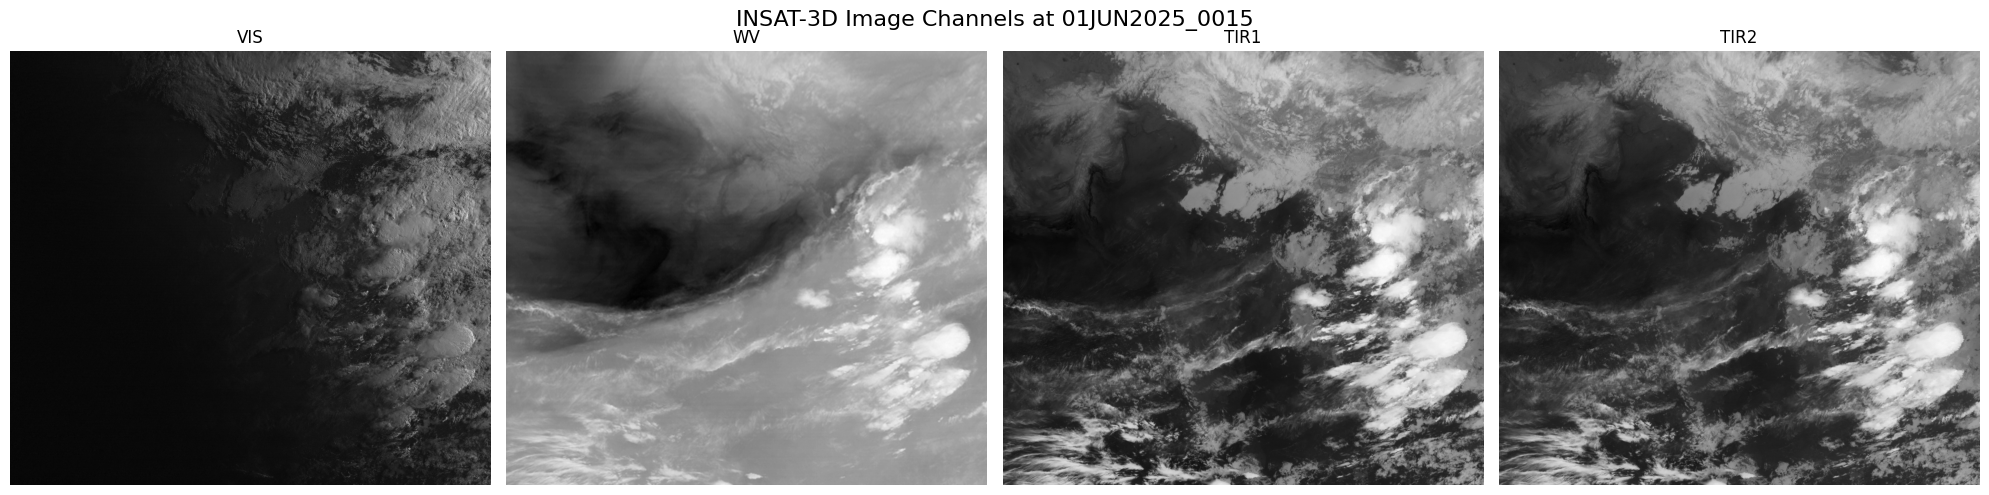

In [ ]:
sample_ts = common_timestamps[0]  # Or pick another

# Build full paths for each channel
def get_filepath(ch, timestamp):
    date, time = timestamp.split('_')
    pattern = f"3RIMG_{date}_{time}_L1C_SGP_V01R00_IMG_{ch.upper()}.tif"
    return os.path.join(base_path, channel_folders[ch], pattern)

# Plot
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, ch in enumerate(channel_folders):
    path = get_filepath(ch, sample_ts)
    with rasterio.open(path) as src:
        img = src.read(1)
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(ch.upper())
    axs[i].axis('off')

plt.suptitle(f'INSAT-3D Image Channels at {sample_ts}', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import rasterio
from tqdm import tqdm
import re
from PIL import Image
from collections import defaultdict

# --- Config ---
base_path = '/content/drive/MyDrive/upload'
channels = ['VIS', 'WV', 'TIR1', 'TIR2']
resize_shape = (128, 128)
input_steps = 6        # 👈 USE 6 input frames
target_steps = 1
save_path = '/content/drive/MyDrive/update_processed2'
os.makedirs(f"{save_path}/input", exist_ok=True)
os.makedirs(f"{save_path}/target", exist_ok=True)

# --- Extract timestamp ---
def extract_timestamp(filename):
    match = re.search(r'3RIMG_(\d{2}[A-Z]{3}\d{4})_(\d{4})_L1C', filename)
    return f"{match.group(1)}_{match.group(2)}" if match else None

# --- Gather files ---
channel_ts = defaultdict(set)
channel_files = defaultdict(dict)

for ch in channels:
    folder = os.path.join(base_path, ch)
    if not os.path.exists(folder):
        print(f"⚠️ Folder not found: {folder}")
        continue
    for fname in os.listdir(folder):
        if fname.endswith('.tif'):
            ts = extract_timestamp(fname)
            if ts:
                channel_ts[ch].add(ts)
                channel_files[ch][ts] = os.path.join(folder, fname)

# --- Common timestamps ---
common_ts = sorted(set.intersection(*[channel_ts[ch] for ch in channels]))
print(f"✅ Found {len(common_ts)} common timestamps")

# --- Normalize and resize ---
def load_and_preprocess(path):
    with rasterio.open(path) as src:
        arr = src.read(1).astype(np.float32)
    arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-5)
    img = Image.fromarray((arr * 255).astype(np.uint8))
    img = img.resize(resize_shape, resample=Image.BILINEAR)
    return np.array(img, dtype=np.float32) / 255.0

# --- Build sequences ---
sequence_id = 0
for i in tqdm(range(len(common_ts) - (input_steps + target_steps) + 1)):
    input_tensor = []
    target_tensor = []
    incomplete = False

    for t in range(i, i + input_steps + target_steps):
        ts = common_ts[t]
        frame = []
        for ch in channels:
            if ts not in channel_files[ch]:
                incomplete = True
                break
            try:
                arr = load_and_preprocess(channel_files[ch][ts])
                frame.append(arr)
            except Exception as e:
                print(f"⚠️ Error loading {channel_files[ch][ts]}: {e}")
                incomplete = True
                break

        if incomplete or len(frame) != len(channels):
            break

        stacked = np.stack(frame, axis=0)  # (4, 128, 128)
        if t < i + input_steps:
            input_tensor.append(stacked)
        else:
            target_tensor.append(stacked)

    # Final save (if sequence was complete)
    if not incomplete and len(input_tensor) == input_steps and len(target_tensor) == target_steps:
        input_tensor = np.concatenate(input_tensor, axis=0)    # (6*4=24, 128, 128)
        target_tensor = target_tensor[0]                       # (4, 128, 128)

        print(f"Saving sequence {sequence_id:04d}: input {input_tensor.shape}, target {target_tensor.shape}")

        np.save(f"{save_path}/input/seq_{sequence_id:04d}.npy", input_tensor)
        np.save(f"{save_path}/target/seq_{sequence_id:04d}.npy", target_tensor)
        sequence_id += 1

print(f"🎉 Saved {sequence_id} input-target sequence pairs.")


✅ Found 573 common timestamps


  0%|          | 1/567 [00:03<31:34,  3.35s/it]

Saving sequence 0000: input (24, 128, 128), target (4, 128, 128)


  0%|          | 2/567 [00:06<32:06,  3.41s/it]

Saving sequence 0001: input (24, 128, 128), target (4, 128, 128)


  1%|          | 3/567 [00:10<34:13,  3.64s/it]

Saving sequence 0002: input (24, 128, 128), target (4, 128, 128)


  1%|          | 4/567 [00:14<34:17,  3.66s/it]

Saving sequence 0003: input (24, 128, 128), target (4, 128, 128)


  1%|          | 5/567 [00:15<26:55,  2.87s/it]

Saving sequence 0004: input (24, 128, 128), target (4, 128, 128)


  1%|          | 6/567 [00:17<22:19,  2.39s/it]

Saving sequence 0005: input (24, 128, 128), target (4, 128, 128)


  1%|          | 7/567 [00:18<19:33,  2.10s/it]

Saving sequence 0006: input (24, 128, 128), target (4, 128, 128)


  1%|▏         | 8/567 [00:20<17:43,  1.90s/it]

Saving sequence 0007: input (24, 128, 128), target (4, 128, 128)


  2%|▏         | 9/567 [00:21<16:42,  1.80s/it]

Saving sequence 0008: input (24, 128, 128), target (4, 128, 128)


  2%|▏         | 10/567 [00:23<17:15,  1.86s/it]

Saving sequence 0009: input (24, 128, 128), target (4, 128, 128)


  2%|▏         | 11/567 [00:25<17:34,  1.90s/it]

Saving sequence 0010: input (24, 128, 128), target (4, 128, 128)


  2%|▏         | 12/567 [00:27<16:33,  1.79s/it]

Saving sequence 0011: input (24, 128, 128), target (4, 128, 128)


  2%|▏         | 13/567 [00:28<15:36,  1.69s/it]

Saving sequence 0012: input (24, 128, 128), target (4, 128, 128)


  2%|▏         | 14/567 [00:30<15:02,  1.63s/it]

Saving sequence 0013: input (24, 128, 128), target (4, 128, 128)


  3%|▎         | 15/567 [00:31<14:25,  1.57s/it]

Saving sequence 0014: input (24, 128, 128), target (4, 128, 128)


  3%|▎         | 16/567 [00:33<14:12,  1.55s/it]

Saving sequence 0015: input (24, 128, 128), target (4, 128, 128)


  3%|▎         | 17/567 [00:34<13:57,  1.52s/it]

Saving sequence 0016: input (24, 128, 128), target (4, 128, 128)


  3%|▎         | 18/567 [00:36<14:24,  1.57s/it]

Saving sequence 0017: input (24, 128, 128), target (4, 128, 128)


  3%|▎         | 19/567 [00:38<16:55,  1.85s/it]

Saving sequence 0018: input (24, 128, 128), target (4, 128, 128)


  4%|▎         | 20/567 [00:41<19:17,  2.12s/it]

Saving sequence 0019: input (24, 128, 128), target (4, 128, 128)


  4%|▎         | 21/567 [00:43<18:06,  1.99s/it]

Saving sequence 0020: input (24, 128, 128), target (4, 128, 128)


  4%|▍         | 22/567 [00:44<16:40,  1.84s/it]

Saving sequence 0021: input (24, 128, 128), target (4, 128, 128)


  4%|▍         | 23/567 [00:46<15:35,  1.72s/it]

Saving sequence 0022: input (24, 128, 128), target (4, 128, 128)


  4%|▍         | 24/567 [00:47<14:45,  1.63s/it]

Saving sequence 0023: input (24, 128, 128), target (4, 128, 128)


  4%|▍         | 25/567 [00:49<14:05,  1.56s/it]

Saving sequence 0024: input (24, 128, 128), target (4, 128, 128)


  5%|▍         | 26/567 [00:50<13:55,  1.54s/it]

Saving sequence 0025: input (24, 128, 128), target (4, 128, 128)


  5%|▍         | 27/567 [00:52<14:07,  1.57s/it]

Saving sequence 0026: input (24, 128, 128), target (4, 128, 128)


  5%|▍         | 28/567 [00:54<14:49,  1.65s/it]

Saving sequence 0027: input (24, 128, 128), target (4, 128, 128)


  5%|▌         | 29/567 [00:55<15:14,  1.70s/it]

Saving sequence 0028: input (24, 128, 128), target (4, 128, 128)


  5%|▌         | 30/567 [00:57<14:30,  1.62s/it]

Saving sequence 0029: input (24, 128, 128), target (4, 128, 128)


  5%|▌         | 31/567 [00:58<13:58,  1.57s/it]

Saving sequence 0030: input (24, 128, 128), target (4, 128, 128)


  6%|▌         | 32/567 [01:00<13:40,  1.53s/it]

Saving sequence 0031: input (24, 128, 128), target (4, 128, 128)


  6%|▌         | 33/567 [01:01<13:26,  1.51s/it]

Saving sequence 0032: input (24, 128, 128), target (4, 128, 128)


  6%|▌         | 34/567 [01:03<13:14,  1.49s/it]

Saving sequence 0033: input (24, 128, 128), target (4, 128, 128)


  6%|▌         | 35/567 [01:04<13:03,  1.47s/it]

Saving sequence 0034: input (24, 128, 128), target (4, 128, 128)


  6%|▋         | 36/567 [01:06<13:45,  1.55s/it]

Saving sequence 0035: input (24, 128, 128), target (4, 128, 128)


  7%|▋         | 37/567 [01:08<14:37,  1.65s/it]

Saving sequence 0036: input (24, 128, 128), target (4, 128, 128)


  7%|▋         | 38/567 [01:09<14:43,  1.67s/it]

Saving sequence 0037: input (24, 128, 128), target (4, 128, 128)


  7%|▋         | 39/567 [01:11<14:06,  1.60s/it]

Saving sequence 0038: input (24, 128, 128), target (4, 128, 128)


  7%|▋         | 40/567 [01:12<13:46,  1.57s/it]

Saving sequence 0039: input (24, 128, 128), target (4, 128, 128)


  7%|▋         | 41/567 [01:14<13:24,  1.53s/it]

Saving sequence 0040: input (24, 128, 128), target (4, 128, 128)


  7%|▋         | 42/567 [01:15<13:12,  1.51s/it]

Saving sequence 0041: input (24, 128, 128), target (4, 128, 128)


  8%|▊         | 43/567 [01:17<12:57,  1.48s/it]

Saving sequence 0042: input (24, 128, 128), target (4, 128, 128)


  8%|▊         | 44/567 [01:18<12:58,  1.49s/it]

Saving sequence 0043: input (24, 128, 128), target (4, 128, 128)


  8%|▊         | 45/567 [01:20<13:36,  1.56s/it]

Saving sequence 0044: input (24, 128, 128), target (4, 128, 128)


  8%|▊         | 46/567 [01:22<14:32,  1.67s/it]

Saving sequence 0045: input (24, 128, 128), target (4, 128, 128)


  8%|▊         | 47/567 [01:24<14:32,  1.68s/it]

Saving sequence 0046: input (24, 128, 128), target (4, 128, 128)


  8%|▊         | 48/567 [01:25<14:19,  1.66s/it]

Saving sequence 0047: input (24, 128, 128), target (4, 128, 128)


  9%|▊         | 49/567 [01:27<13:58,  1.62s/it]

Saving sequence 0048: input (24, 128, 128), target (4, 128, 128)


  9%|▉         | 50/567 [01:28<13:31,  1.57s/it]

Saving sequence 0049: input (24, 128, 128), target (4, 128, 128)


  9%|▉         | 51/567 [01:30<14:14,  1.66s/it]

Saving sequence 0050: input (24, 128, 128), target (4, 128, 128)


  9%|▉         | 52/567 [01:31<13:44,  1.60s/it]

Saving sequence 0051: input (24, 128, 128), target (4, 128, 128)


  9%|▉         | 53/567 [01:33<13:35,  1.59s/it]

Saving sequence 0052: input (24, 128, 128), target (4, 128, 128)


 10%|▉         | 54/567 [01:35<14:29,  1.70s/it]

Saving sequence 0053: input (24, 128, 128), target (4, 128, 128)


 10%|▉         | 55/567 [01:37<15:04,  1.77s/it]

Saving sequence 0054: input (24, 128, 128), target (4, 128, 128)


 10%|▉         | 56/567 [01:38<14:25,  1.69s/it]

Saving sequence 0055: input (24, 128, 128), target (4, 128, 128)


 10%|█         | 57/567 [01:40<13:57,  1.64s/it]

Saving sequence 0056: input (24, 128, 128), target (4, 128, 128)


 10%|█         | 58/567 [01:41<13:43,  1.62s/it]

Saving sequence 0057: input (24, 128, 128), target (4, 128, 128)


 10%|█         | 59/567 [01:43<13:25,  1.58s/it]

Saving sequence 0058: input (24, 128, 128), target (4, 128, 128)


 11%|█         | 60/567 [01:45<13:17,  1.57s/it]

Saving sequence 0059: input (24, 128, 128), target (4, 128, 128)


 11%|█         | 61/567 [01:46<13:11,  1.56s/it]

Saving sequence 0060: input (24, 128, 128), target (4, 128, 128)


 11%|█         | 62/567 [01:48<13:48,  1.64s/it]

Saving sequence 0061: input (24, 128, 128), target (4, 128, 128)


 11%|█         | 63/567 [01:50<14:43,  1.75s/it]

Saving sequence 0062: input (24, 128, 128), target (4, 128, 128)


 11%|█▏        | 64/567 [01:52<14:32,  1.73s/it]

Saving sequence 0063: input (24, 128, 128), target (4, 128, 128)


 11%|█▏        | 65/567 [01:53<13:54,  1.66s/it]

Saving sequence 0064: input (24, 128, 128), target (4, 128, 128)


 12%|█▏        | 66/567 [01:55<14:29,  1.74s/it]

Saving sequence 0065: input (24, 128, 128), target (4, 128, 128)


 12%|█▏        | 67/567 [01:57<14:42,  1.76s/it]

Saving sequence 0066: input (24, 128, 128), target (4, 128, 128)


 12%|█▏        | 68/567 [01:58<13:58,  1.68s/it]

Saving sequence 0067: input (24, 128, 128), target (4, 128, 128)


 12%|█▏        | 69/567 [02:00<13:35,  1.64s/it]

Saving sequence 0068: input (24, 128, 128), target (4, 128, 128)


 12%|█▏        | 70/567 [02:04<18:58,  2.29s/it]

Saving sequence 0069: input (24, 128, 128), target (4, 128, 128)


 13%|█▎        | 71/567 [02:07<21:48,  2.64s/it]

Saving sequence 0070: input (24, 128, 128), target (4, 128, 128)


 13%|█▎        | 72/567 [02:10<23:32,  2.85s/it]

Saving sequence 0071: input (24, 128, 128), target (4, 128, 128)


 13%|█▎        | 73/567 [02:12<20:12,  2.45s/it]

Saving sequence 0072: input (24, 128, 128), target (4, 128, 128)


 13%|█▎        | 74/567 [02:16<22:53,  2.79s/it]

Saving sequence 0073: input (24, 128, 128), target (4, 128, 128)


 13%|█▎        | 75/567 [02:18<20:47,  2.54s/it]

Saving sequence 0074: input (24, 128, 128), target (4, 128, 128)


 13%|█▎        | 76/567 [02:19<18:32,  2.27s/it]

Saving sequence 0075: input (24, 128, 128), target (4, 128, 128)


 14%|█▎        | 77/567 [02:21<16:36,  2.03s/it]

Saving sequence 0076: input (24, 128, 128), target (4, 128, 128)


 14%|█▍        | 78/567 [02:22<15:08,  1.86s/it]

Saving sequence 0077: input (24, 128, 128), target (4, 128, 128)


 14%|█▍        | 79/567 [02:24<14:10,  1.74s/it]

Saving sequence 0078: input (24, 128, 128), target (4, 128, 128)


 14%|█▍        | 80/567 [02:25<13:31,  1.67s/it]

Saving sequence 0079: input (24, 128, 128), target (4, 128, 128)


 14%|█▍        | 81/567 [02:27<12:58,  1.60s/it]

Saving sequence 0080: input (24, 128, 128), target (4, 128, 128)


 14%|█▍        | 82/567 [02:28<12:37,  1.56s/it]

Saving sequence 0081: input (24, 128, 128), target (4, 128, 128)


 15%|█▍        | 83/567 [02:30<13:08,  1.63s/it]

Saving sequence 0082: input (24, 128, 128), target (4, 128, 128)


 15%|█▍        | 84/567 [02:32<13:51,  1.72s/it]

Saving sequence 0083: input (24, 128, 128), target (4, 128, 128)


 15%|█▍        | 85/567 [02:33<13:30,  1.68s/it]

Saving sequence 0084: input (24, 128, 128), target (4, 128, 128)


 15%|█▌        | 86/567 [02:35<12:55,  1.61s/it]

Saving sequence 0085: input (24, 128, 128), target (4, 128, 128)


 15%|█▌        | 87/567 [02:36<12:32,  1.57s/it]

Saving sequence 0086: input (24, 128, 128), target (4, 128, 128)


 16%|█▌        | 88/567 [02:38<12:11,  1.53s/it]

Saving sequence 0087: input (24, 128, 128), target (4, 128, 128)


 16%|█▌        | 89/567 [02:39<12:12,  1.53s/it]

Saving sequence 0088: input (24, 128, 128), target (4, 128, 128)


 16%|█▌        | 90/567 [02:41<12:05,  1.52s/it]

Saving sequence 0089: input (24, 128, 128), target (4, 128, 128)


 16%|█▌        | 91/567 [02:42<11:51,  1.49s/it]

Saving sequence 0090: input (24, 128, 128), target (4, 128, 128)


 16%|█▌        | 92/567 [02:44<12:53,  1.63s/it]

Saving sequence 0091: input (24, 128, 128), target (4, 128, 128)


 16%|█▋        | 93/567 [02:46<13:34,  1.72s/it]

Saving sequence 0092: input (24, 128, 128), target (4, 128, 128)


 17%|█▋        | 94/567 [02:48<13:05,  1.66s/it]

Saving sequence 0093: input (24, 128, 128), target (4, 128, 128)


 17%|█▋        | 95/567 [02:49<12:36,  1.60s/it]

Saving sequence 0094: input (24, 128, 128), target (4, 128, 128)


 17%|█▋        | 96/567 [02:50<12:15,  1.56s/it]

Saving sequence 0095: input (24, 128, 128), target (4, 128, 128)


 17%|█▋        | 97/567 [02:52<12:05,  1.54s/it]

Saving sequence 0096: input (24, 128, 128), target (4, 128, 128)


 17%|█▋        | 98/567 [02:53<11:50,  1.51s/it]

Saving sequence 0097: input (24, 128, 128), target (4, 128, 128)


 17%|█▋        | 99/567 [02:55<11:50,  1.52s/it]

Saving sequence 0098: input (24, 128, 128), target (4, 128, 128)


 18%|█▊        | 100/567 [02:56<11:57,  1.54s/it]

Saving sequence 0099: input (24, 128, 128), target (4, 128, 128)


 18%|█▊        | 101/567 [02:59<13:03,  1.68s/it]

Saving sequence 0100: input (24, 128, 128), target (4, 128, 128)


 18%|█▊        | 102/567 [03:00<13:35,  1.75s/it]

Saving sequence 0101: input (24, 128, 128), target (4, 128, 128)


 18%|█▊        | 103/567 [03:02<12:56,  1.67s/it]

Saving sequence 0102: input (24, 128, 128), target (4, 128, 128)


 18%|█▊        | 104/567 [03:03<12:31,  1.62s/it]

Saving sequence 0103: input (24, 128, 128), target (4, 128, 128)


 19%|█▊        | 105/567 [03:05<12:17,  1.60s/it]

Saving sequence 0104: input (24, 128, 128), target (4, 128, 128)


 19%|█▊        | 106/567 [03:06<12:03,  1.57s/it]

Saving sequence 0105: input (24, 128, 128), target (4, 128, 128)


 19%|█▉        | 107/567 [03:08<11:59,  1.56s/it]

Saving sequence 0106: input (24, 128, 128), target (4, 128, 128)


 19%|█▉        | 108/567 [03:09<11:46,  1.54s/it]

Saving sequence 0107: input (24, 128, 128), target (4, 128, 128)


 19%|█▉        | 109/567 [03:11<12:37,  1.65s/it]

Saving sequence 0108: input (24, 128, 128), target (4, 128, 128)


 19%|█▉        | 110/567 [03:13<13:28,  1.77s/it]

Saving sequence 0109: input (24, 128, 128), target (4, 128, 128)


 20%|█▉        | 111/567 [03:15<13:15,  1.75s/it]

Saving sequence 0110: input (24, 128, 128), target (4, 128, 128)


 20%|█▉        | 112/567 [03:17<12:33,  1.66s/it]

Saving sequence 0111: input (24, 128, 128), target (4, 128, 128)


 20%|█▉        | 113/567 [03:18<12:01,  1.59s/it]

Saving sequence 0112: input (24, 128, 128), target (4, 128, 128)


 20%|██        | 114/567 [03:19<11:42,  1.55s/it]

Saving sequence 0113: input (24, 128, 128), target (4, 128, 128)


 20%|██        | 115/567 [03:21<11:26,  1.52s/it]

Saving sequence 0114: input (24, 128, 128), target (4, 128, 128)


 20%|██        | 116/567 [03:22<11:23,  1.52s/it]

Saving sequence 0115: input (24, 128, 128), target (4, 128, 128)


 21%|██        | 117/567 [03:24<11:17,  1.51s/it]

Saving sequence 0116: input (24, 128, 128), target (4, 128, 128)


 21%|██        | 118/567 [03:26<12:14,  1.64s/it]

Saving sequence 0117: input (24, 128, 128), target (4, 128, 128)


 21%|██        | 119/567 [03:28<12:58,  1.74s/it]

Saving sequence 0118: input (24, 128, 128), target (4, 128, 128)


 21%|██        | 120/567 [03:29<12:29,  1.68s/it]

Saving sequence 0119: input (24, 128, 128), target (4, 128, 128)


 21%|██▏       | 121/567 [03:31<12:11,  1.64s/it]

Saving sequence 0120: input (24, 128, 128), target (4, 128, 128)


 22%|██▏       | 122/567 [03:32<11:43,  1.58s/it]

Saving sequence 0121: input (24, 128, 128), target (4, 128, 128)


 22%|██▏       | 123/567 [03:34<11:22,  1.54s/it]

Saving sequence 0122: input (24, 128, 128), target (4, 128, 128)


 22%|██▏       | 124/567 [03:35<11:14,  1.52s/it]

Saving sequence 0123: input (24, 128, 128), target (4, 128, 128)


 22%|██▏       | 125/567 [03:37<11:04,  1.50s/it]

Saving sequence 0124: input (24, 128, 128), target (4, 128, 128)


 22%|██▏       | 126/567 [03:38<10:58,  1.49s/it]

Saving sequence 0125: input (24, 128, 128), target (4, 128, 128)


 22%|██▏       | 127/567 [03:40<11:54,  1.62s/it]

Saving sequence 0126: input (24, 128, 128), target (4, 128, 128)


 23%|██▎       | 128/567 [03:42<13:08,  1.80s/it]

Saving sequence 0127: input (24, 128, 128), target (4, 128, 128)


 23%|██▎       | 129/567 [03:44<12:20,  1.69s/it]

Saving sequence 0128: input (24, 128, 128), target (4, 128, 128)


 23%|██▎       | 130/567 [03:45<11:46,  1.62s/it]

Saving sequence 0129: input (24, 128, 128), target (4, 128, 128)


 23%|██▎       | 131/567 [03:47<11:22,  1.57s/it]

Saving sequence 0130: input (24, 128, 128), target (4, 128, 128)


 23%|██▎       | 132/567 [03:48<11:08,  1.54s/it]

Saving sequence 0131: input (24, 128, 128), target (4, 128, 128)


 23%|██▎       | 133/567 [03:50<10:50,  1.50s/it]

Saving sequence 0132: input (24, 128, 128), target (4, 128, 128)


 24%|██▎       | 134/567 [03:51<10:42,  1.48s/it]

Saving sequence 0133: input (24, 128, 128), target (4, 128, 128)


 24%|██▍       | 135/567 [03:52<10:38,  1.48s/it]

Saving sequence 0134: input (24, 128, 128), target (4, 128, 128)


 24%|██▍       | 136/567 [03:54<11:46,  1.64s/it]

Saving sequence 0135: input (24, 128, 128), target (4, 128, 128)


 24%|██▍       | 137/567 [03:56<12:27,  1.74s/it]

Saving sequence 0136: input (24, 128, 128), target (4, 128, 128)


 24%|██▍       | 138/567 [03:58<11:53,  1.66s/it]

Saving sequence 0137: input (24, 128, 128), target (4, 128, 128)


 25%|██▍       | 139/567 [03:59<11:24,  1.60s/it]

Saving sequence 0138: input (24, 128, 128), target (4, 128, 128)


 25%|██▍       | 140/567 [04:01<11:04,  1.56s/it]

Saving sequence 0139: input (24, 128, 128), target (4, 128, 128)


 25%|██▍       | 141/567 [04:04<14:34,  2.05s/it]

Saving sequence 0140: input (24, 128, 128), target (4, 128, 128)


 25%|██▌       | 142/567 [04:08<17:33,  2.48s/it]

Saving sequence 0141: input (24, 128, 128), target (4, 128, 128)


 25%|██▌       | 143/567 [04:11<20:15,  2.87s/it]

Saving sequence 0142: input (24, 128, 128), target (4, 128, 128)


 25%|██▌       | 144/567 [04:14<20:53,  2.96s/it]

Saving sequence 0143: input (24, 128, 128), target (4, 128, 128)


 26%|██▌       | 145/567 [04:16<17:44,  2.52s/it]

Saving sequence 0144: input (24, 128, 128), target (4, 128, 128)


 26%|██▌       | 146/567 [04:17<15:31,  2.21s/it]

Saving sequence 0145: input (24, 128, 128), target (4, 128, 128)


 26%|██▌       | 147/567 [04:19<13:51,  1.98s/it]

Saving sequence 0146: input (24, 128, 128), target (4, 128, 128)


 26%|██▌       | 148/567 [04:20<12:56,  1.85s/it]

Saving sequence 0147: input (24, 128, 128), target (4, 128, 128)


 26%|██▋       | 149/567 [04:22<13:12,  1.90s/it]

Saving sequence 0148: input (24, 128, 128), target (4, 128, 128)


 26%|██▋       | 150/567 [04:24<13:13,  1.90s/it]

Saving sequence 0149: input (24, 128, 128), target (4, 128, 128)


 27%|██▋       | 151/567 [04:26<12:21,  1.78s/it]

Saving sequence 0150: input (24, 128, 128), target (4, 128, 128)


 27%|██▋       | 152/567 [04:27<11:46,  1.70s/it]

Saving sequence 0151: input (24, 128, 128), target (4, 128, 128)


 27%|██▋       | 153/567 [04:29<11:38,  1.69s/it]

Saving sequence 0152: input (24, 128, 128), target (4, 128, 128)


 27%|██▋       | 154/567 [04:31<11:09,  1.62s/it]

Saving sequence 0153: input (24, 128, 128), target (4, 128, 128)


 27%|██▋       | 155/567 [04:32<10:58,  1.60s/it]

Saving sequence 0154: input (24, 128, 128), target (4, 128, 128)


 28%|██▊       | 156/567 [04:34<10:39,  1.56s/it]

Saving sequence 0155: input (24, 128, 128), target (4, 128, 128)


 28%|██▊       | 157/567 [04:35<11:01,  1.61s/it]

Saving sequence 0156: input (24, 128, 128), target (4, 128, 128)


 28%|██▊       | 158/567 [04:37<11:43,  1.72s/it]

Saving sequence 0157: input (24, 128, 128), target (4, 128, 128)


 28%|██▊       | 159/567 [04:39<11:40,  1.72s/it]

Saving sequence 0158: input (24, 128, 128), target (4, 128, 128)


 28%|██▊       | 160/567 [04:40<11:09,  1.64s/it]

Saving sequence 0159: input (24, 128, 128), target (4, 128, 128)


 28%|██▊       | 161/567 [04:42<10:41,  1.58s/it]

Saving sequence 0160: input (24, 128, 128), target (4, 128, 128)


 29%|██▊       | 162/567 [04:43<10:26,  1.55s/it]

Saving sequence 0161: input (24, 128, 128), target (4, 128, 128)


 29%|██▊       | 163/567 [04:45<10:21,  1.54s/it]

Saving sequence 0162: input (24, 128, 128), target (4, 128, 128)


 29%|██▉       | 164/567 [04:46<10:09,  1.51s/it]

Saving sequence 0163: input (24, 128, 128), target (4, 128, 128)


 29%|██▉       | 165/567 [04:48<10:07,  1.51s/it]

Saving sequence 0164: input (24, 128, 128), target (4, 128, 128)


 29%|██▉       | 166/567 [04:50<10:53,  1.63s/it]

Saving sequence 0165: input (24, 128, 128), target (4, 128, 128)


 29%|██▉       | 167/567 [04:52<11:36,  1.74s/it]

Saving sequence 0166: input (24, 128, 128), target (4, 128, 128)


 30%|██▉       | 168/567 [04:53<11:13,  1.69s/it]

Saving sequence 0167: input (24, 128, 128), target (4, 128, 128)


 30%|██▉       | 169/567 [04:55<10:59,  1.66s/it]

Saving sequence 0168: input (24, 128, 128), target (4, 128, 128)


 30%|██▉       | 170/567 [04:56<10:37,  1.61s/it]

Saving sequence 0169: input (24, 128, 128), target (4, 128, 128)


 30%|███       | 171/567 [04:58<10:45,  1.63s/it]

Saving sequence 0170: input (24, 128, 128), target (4, 128, 128)


 30%|███       | 172/567 [05:00<11:14,  1.71s/it]

Saving sequence 0171: input (24, 128, 128), target (4, 128, 128)


 31%|███       | 173/567 [05:02<11:30,  1.75s/it]

Saving sequence 0172: input (24, 128, 128), target (4, 128, 128)


 31%|███       | 174/567 [05:04<11:48,  1.80s/it]

Saving sequence 0173: input (24, 128, 128), target (4, 128, 128)


 31%|███       | 175/567 [05:06<12:02,  1.84s/it]

Saving sequence 0174: input (24, 128, 128), target (4, 128, 128)


 31%|███       | 176/567 [05:07<11:13,  1.72s/it]

Saving sequence 0175: input (24, 128, 128), target (4, 128, 128)


 31%|███       | 177/567 [05:09<10:37,  1.63s/it]

Saving sequence 0176: input (24, 128, 128), target (4, 128, 128)


 31%|███▏      | 178/567 [05:10<10:20,  1.60s/it]

Saving sequence 0177: input (24, 128, 128), target (4, 128, 128)


 32%|███▏      | 179/567 [05:11<10:05,  1.56s/it]

Saving sequence 0178: input (24, 128, 128), target (4, 128, 128)


 32%|███▏      | 180/567 [05:13<09:52,  1.53s/it]

Saving sequence 0179: input (24, 128, 128), target (4, 128, 128)


 32%|███▏      | 181/567 [05:14<09:37,  1.50s/it]

Saving sequence 0180: input (24, 128, 128), target (4, 128, 128)


 32%|███▏      | 182/567 [05:16<09:38,  1.50s/it]

Saving sequence 0181: input (24, 128, 128), target (4, 128, 128)


 32%|███▏      | 183/567 [05:18<10:21,  1.62s/it]

Saving sequence 0182: input (24, 128, 128), target (4, 128, 128)


 32%|███▏      | 184/567 [05:20<10:48,  1.69s/it]

Saving sequence 0183: input (24, 128, 128), target (4, 128, 128)


 33%|███▎      | 185/567 [05:21<10:27,  1.64s/it]

Saving sequence 0184: input (24, 128, 128), target (4, 128, 128)


 33%|███▎      | 186/567 [05:23<10:01,  1.58s/it]

Saving sequence 0185: input (24, 128, 128), target (4, 128, 128)


 33%|███▎      | 187/567 [05:24<09:49,  1.55s/it]

Saving sequence 0186: input (24, 128, 128), target (4, 128, 128)


 33%|███▎      | 188/567 [05:26<09:39,  1.53s/it]

Saving sequence 0187: input (24, 128, 128), target (4, 128, 128)


 33%|███▎      | 189/567 [05:27<09:33,  1.52s/it]

Saving sequence 0188: input (24, 128, 128), target (4, 128, 128)


 34%|███▎      | 190/567 [05:29<09:29,  1.51s/it]

Saving sequence 0189: input (24, 128, 128), target (4, 128, 128)


 34%|███▎      | 191/567 [05:30<09:55,  1.58s/it]

Saving sequence 0190: input (24, 128, 128), target (4, 128, 128)


 34%|███▍      | 192/567 [05:32<10:38,  1.70s/it]

Saving sequence 0191: input (24, 128, 128), target (4, 128, 128)


 34%|███▍      | 193/567 [05:34<10:30,  1.68s/it]

Saving sequence 0192: input (24, 128, 128), target (4, 128, 128)


 34%|███▍      | 194/567 [05:35<10:06,  1.63s/it]

Saving sequence 0193: input (24, 128, 128), target (4, 128, 128)


 34%|███▍      | 195/567 [05:37<09:47,  1.58s/it]

Saving sequence 0194: input (24, 128, 128), target (4, 128, 128)


 35%|███▍      | 196/567 [05:38<09:38,  1.56s/it]

Saving sequence 0195: input (24, 128, 128), target (4, 128, 128)


 35%|███▍      | 197/567 [05:40<09:25,  1.53s/it]

Saving sequence 0196: input (24, 128, 128), target (4, 128, 128)


 35%|███▍      | 198/567 [05:41<09:23,  1.53s/it]

Saving sequence 0197: input (24, 128, 128), target (4, 128, 128)


 35%|███▌      | 199/567 [05:43<09:18,  1.52s/it]

Saving sequence 0198: input (24, 128, 128), target (4, 128, 128)


 35%|███▌      | 200/567 [05:45<10:04,  1.65s/it]

Saving sequence 0199: input (24, 128, 128), target (4, 128, 128)


 35%|███▌      | 201/567 [05:47<10:57,  1.80s/it]

Saving sequence 0200: input (24, 128, 128), target (4, 128, 128)


 36%|███▌      | 202/567 [05:48<10:19,  1.70s/it]

Saving sequence 0201: input (24, 128, 128), target (4, 128, 128)


 36%|███▌      | 203/567 [05:50<09:58,  1.64s/it]

Saving sequence 0202: input (24, 128, 128), target (4, 128, 128)


 36%|███▌      | 204/567 [05:51<09:43,  1.61s/it]

Saving sequence 0203: input (24, 128, 128), target (4, 128, 128)


 36%|███▌      | 205/567 [05:53<09:28,  1.57s/it]

Saving sequence 0204: input (24, 128, 128), target (4, 128, 128)


 36%|███▋      | 206/567 [05:54<09:22,  1.56s/it]

Saving sequence 0205: input (24, 128, 128), target (4, 128, 128)


 37%|███▋      | 207/567 [05:56<09:11,  1.53s/it]

Saving sequence 0206: input (24, 128, 128), target (4, 128, 128)


 37%|███▋      | 208/567 [05:58<09:32,  1.60s/it]

Saving sequence 0207: input (24, 128, 128), target (4, 128, 128)


 37%|███▋      | 209/567 [06:00<10:13,  1.71s/it]

Saving sequence 0208: input (24, 128, 128), target (4, 128, 128)


 37%|███▋      | 210/567 [06:03<13:16,  2.23s/it]

Saving sequence 0209: input (24, 128, 128), target (4, 128, 128)


 37%|███▋      | 211/567 [06:05<11:53,  2.01s/it]

Saving sequence 0210: input (24, 128, 128), target (4, 128, 128)


 37%|███▋      | 212/567 [06:06<10:52,  1.84s/it]

Saving sequence 0211: input (24, 128, 128), target (4, 128, 128)


 38%|███▊      | 213/567 [06:08<10:09,  1.72s/it]

Saving sequence 0212: input (24, 128, 128), target (4, 128, 128)


 38%|███▊      | 214/567 [06:09<09:37,  1.63s/it]

Saving sequence 0213: input (24, 128, 128), target (4, 128, 128)


 38%|███▊      | 215/567 [06:13<13:25,  2.29s/it]

Saving sequence 0214: input (24, 128, 128), target (4, 128, 128)


 38%|███▊      | 216/567 [06:16<15:34,  2.66s/it]

Saving sequence 0215: input (24, 128, 128), target (4, 128, 128)


 38%|███▊      | 217/567 [06:20<16:34,  2.84s/it]

Saving sequence 0216: input (24, 128, 128), target (4, 128, 128)


 38%|███▊      | 218/567 [06:21<14:01,  2.41s/it]

Saving sequence 0217: input (24, 128, 128), target (4, 128, 128)


 39%|███▊      | 219/567 [06:22<12:19,  2.13s/it]

Saving sequence 0218: input (24, 128, 128), target (4, 128, 128)


 39%|███▉      | 220/567 [06:24<11:05,  1.92s/it]

Saving sequence 0219: input (24, 128, 128), target (4, 128, 128)


 39%|███▉      | 221/567 [06:26<10:54,  1.89s/it]

Saving sequence 0220: input (24, 128, 128), target (4, 128, 128)


 39%|███▉      | 222/567 [06:28<10:59,  1.91s/it]

Saving sequence 0221: input (24, 128, 128), target (4, 128, 128)


 39%|███▉      | 223/567 [06:29<10:14,  1.79s/it]

Saving sequence 0222: input (24, 128, 128), target (4, 128, 128)


 40%|███▉      | 224/567 [06:31<09:36,  1.68s/it]

Saving sequence 0223: input (24, 128, 128), target (4, 128, 128)


 40%|███▉      | 225/567 [06:32<09:11,  1.61s/it]

Saving sequence 0224: input (24, 128, 128), target (4, 128, 128)


 40%|███▉      | 226/567 [06:33<08:52,  1.56s/it]

Saving sequence 0225: input (24, 128, 128), target (4, 128, 128)


 40%|████      | 227/567 [06:35<08:37,  1.52s/it]

Saving sequence 0226: input (24, 128, 128), target (4, 128, 128)


 40%|████      | 228/567 [06:36<08:25,  1.49s/it]

Saving sequence 0227: input (24, 128, 128), target (4, 128, 128)


 40%|████      | 229/567 [06:38<08:24,  1.49s/it]

Saving sequence 0228: input (24, 128, 128), target (4, 128, 128)


 41%|████      | 230/567 [06:40<09:07,  1.63s/it]

Saving sequence 0229: input (24, 128, 128), target (4, 128, 128)


 41%|████      | 231/567 [06:42<09:34,  1.71s/it]

Saving sequence 0230: input (24, 128, 128), target (4, 128, 128)


 41%|████      | 232/567 [06:43<09:04,  1.62s/it]

Saving sequence 0231: input (24, 128, 128), target (4, 128, 128)


 41%|████      | 233/567 [06:45<08:54,  1.60s/it]

Saving sequence 0232: input (24, 128, 128), target (4, 128, 128)


 41%|████▏     | 234/567 [06:46<08:37,  1.55s/it]

Saving sequence 0233: input (24, 128, 128), target (4, 128, 128)


 41%|████▏     | 235/567 [06:48<08:29,  1.54s/it]

Saving sequence 0234: input (24, 128, 128), target (4, 128, 128)


 42%|████▏     | 236/567 [06:49<08:16,  1.50s/it]

Saving sequence 0235: input (24, 128, 128), target (4, 128, 128)


 42%|████▏     | 237/567 [06:50<08:11,  1.49s/it]

Saving sequence 0236: input (24, 128, 128), target (4, 128, 128)


 42%|████▏     | 238/567 [06:52<08:23,  1.53s/it]

Saving sequence 0237: input (24, 128, 128), target (4, 128, 128)


 42%|████▏     | 239/567 [06:54<09:02,  1.65s/it]

Saving sequence 0238: input (24, 128, 128), target (4, 128, 128)


 42%|████▏     | 240/567 [06:56<09:13,  1.69s/it]

Saving sequence 0239: input (24, 128, 128), target (4, 128, 128)


 43%|████▎     | 241/567 [06:57<08:49,  1.62s/it]

Saving sequence 0240: input (24, 128, 128), target (4, 128, 128)


 43%|████▎     | 242/567 [06:59<08:31,  1.57s/it]

Saving sequence 0241: input (24, 128, 128), target (4, 128, 128)


 43%|████▎     | 243/567 [07:01<09:04,  1.68s/it]

Saving sequence 0242: input (24, 128, 128), target (4, 128, 128)


 43%|████▎     | 244/567 [07:04<11:23,  2.12s/it]

Saving sequence 0243: input (24, 128, 128), target (4, 128, 128)


 43%|████▎     | 245/567 [07:06<11:32,  2.15s/it]

Saving sequence 0244: input (24, 128, 128), target (4, 128, 128)


 43%|████▎     | 246/567 [07:08<11:17,  2.11s/it]

Saving sequence 0245: input (24, 128, 128), target (4, 128, 128)


 44%|████▎     | 247/567 [07:10<10:42,  2.01s/it]

Saving sequence 0246: input (24, 128, 128), target (4, 128, 128)


 44%|████▎     | 248/567 [07:11<09:52,  1.86s/it]

Saving sequence 0247: input (24, 128, 128), target (4, 128, 128)


 44%|████▍     | 249/567 [07:13<09:28,  1.79s/it]

Saving sequence 0248: input (24, 128, 128), target (4, 128, 128)


 44%|████▍     | 250/567 [07:15<09:10,  1.74s/it]

Saving sequence 0249: input (24, 128, 128), target (4, 128, 128)


 44%|████▍     | 251/567 [07:16<08:43,  1.66s/it]

Saving sequence 0250: input (24, 128, 128), target (4, 128, 128)


 44%|████▍     | 252/567 [07:18<08:33,  1.63s/it]

Saving sequence 0251: input (24, 128, 128), target (4, 128, 128)


 45%|████▍     | 253/567 [07:19<08:24,  1.61s/it]

Saving sequence 0252: input (24, 128, 128), target (4, 128, 128)


 45%|████▍     | 254/567 [07:21<09:01,  1.73s/it]

Saving sequence 0253: input (24, 128, 128), target (4, 128, 128)


 45%|████▍     | 255/567 [07:23<09:29,  1.82s/it]

Saving sequence 0254: input (24, 128, 128), target (4, 128, 128)


 45%|████▌     | 256/567 [07:25<08:56,  1.73s/it]

Saving sequence 0255: input (24, 128, 128), target (4, 128, 128)


 45%|████▌     | 257/567 [07:26<08:34,  1.66s/it]

Saving sequence 0256: input (24, 128, 128), target (4, 128, 128)


 46%|████▌     | 258/567 [07:28<08:17,  1.61s/it]

Saving sequence 0257: input (24, 128, 128), target (4, 128, 128)


 46%|████▌     | 259/567 [07:29<08:04,  1.57s/it]

Saving sequence 0258: input (24, 128, 128), target (4, 128, 128)


 46%|████▌     | 260/567 [07:31<07:56,  1.55s/it]

Saving sequence 0259: input (24, 128, 128), target (4, 128, 128)


 46%|████▌     | 261/567 [07:32<07:47,  1.53s/it]

Saving sequence 0260: input (24, 128, 128), target (4, 128, 128)


 46%|████▌     | 262/567 [07:34<08:06,  1.60s/it]

Saving sequence 0261: input (24, 128, 128), target (4, 128, 128)


 46%|████▋     | 263/567 [07:36<08:31,  1.68s/it]

Saving sequence 0262: input (24, 128, 128), target (4, 128, 128)


 47%|████▋     | 264/567 [07:38<08:33,  1.69s/it]

Saving sequence 0263: input (24, 128, 128), target (4, 128, 128)


 47%|████▋     | 265/567 [07:39<08:10,  1.63s/it]

Saving sequence 0264: input (24, 128, 128), target (4, 128, 128)


 47%|████▋     | 266/567 [07:40<08:00,  1.60s/it]

Saving sequence 0265: input (24, 128, 128), target (4, 128, 128)


 47%|████▋     | 267/567 [07:42<07:46,  1.56s/it]

Saving sequence 0266: input (24, 128, 128), target (4, 128, 128)


 47%|████▋     | 268/567 [07:43<07:33,  1.52s/it]

Saving sequence 0267: input (24, 128, 128), target (4, 128, 128)


 47%|████▋     | 269/567 [07:45<07:31,  1.52s/it]

Saving sequence 0268: input (24, 128, 128), target (4, 128, 128)


 48%|████▊     | 270/567 [07:46<07:22,  1.49s/it]

Saving sequence 0269: input (24, 128, 128), target (4, 128, 128)


 48%|████▊     | 271/567 [07:48<07:58,  1.62s/it]

Saving sequence 0270: input (24, 128, 128), target (4, 128, 128)


 48%|████▊     | 272/567 [07:50<08:26,  1.72s/it]

Saving sequence 0271: input (24, 128, 128), target (4, 128, 128)


 48%|████▊     | 273/567 [07:52<08:01,  1.64s/it]

Saving sequence 0272: input (24, 128, 128), target (4, 128, 128)


 48%|████▊     | 274/567 [07:53<07:47,  1.59s/it]

Saving sequence 0273: input (24, 128, 128), target (4, 128, 128)


 49%|████▊     | 275/567 [07:55<07:31,  1.55s/it]

Saving sequence 0274: input (24, 128, 128), target (4, 128, 128)


 49%|████▊     | 276/567 [07:56<07:21,  1.52s/it]

Saving sequence 0275: input (24, 128, 128), target (4, 128, 128)


 49%|████▉     | 277/567 [07:57<07:15,  1.50s/it]

Saving sequence 0276: input (24, 128, 128), target (4, 128, 128)


 49%|████▉     | 278/567 [07:59<07:09,  1.49s/it]

Saving sequence 0277: input (24, 128, 128), target (4, 128, 128)


 49%|████▉     | 279/567 [08:00<07:12,  1.50s/it]

Saving sequence 0278: input (24, 128, 128), target (4, 128, 128)


 49%|████▉     | 280/567 [08:02<07:44,  1.62s/it]

Saving sequence 0279: input (24, 128, 128), target (4, 128, 128)


 50%|████▉     | 281/567 [08:04<08:17,  1.74s/it]

Saving sequence 0280: input (24, 128, 128), target (4, 128, 128)


 50%|████▉     | 282/567 [08:06<07:52,  1.66s/it]

Saving sequence 0281: input (24, 128, 128), target (4, 128, 128)


 50%|████▉     | 283/567 [08:07<07:30,  1.59s/it]

Saving sequence 0282: input (24, 128, 128), target (4, 128, 128)


 50%|█████     | 284/567 [08:09<07:19,  1.55s/it]

Saving sequence 0283: input (24, 128, 128), target (4, 128, 128)


 50%|█████     | 285/567 [08:12<09:51,  2.10s/it]

Saving sequence 0284: input (24, 128, 128), target (4, 128, 128)


 50%|█████     | 286/567 [08:16<12:03,  2.57s/it]

Saving sequence 0285: input (24, 128, 128), target (4, 128, 128)


 51%|█████     | 287/567 [08:19<13:28,  2.89s/it]

Saving sequence 0286: input (24, 128, 128), target (4, 128, 128)


 51%|█████     | 288/567 [08:23<14:00,  3.01s/it]

Saving sequence 0287: input (24, 128, 128), target (4, 128, 128)


 51%|█████     | 289/567 [08:24<11:52,  2.56s/it]

Saving sequence 0288: input (24, 128, 128), target (4, 128, 128)


 51%|█████     | 290/567 [08:26<10:21,  2.24s/it]

Saving sequence 0289: input (24, 128, 128), target (4, 128, 128)


 51%|█████▏    | 291/567 [08:27<09:18,  2.02s/it]

Saving sequence 0290: input (24, 128, 128), target (4, 128, 128)


 51%|█████▏    | 292/567 [08:29<09:04,  1.98s/it]

Saving sequence 0291: input (24, 128, 128), target (4, 128, 128)


 52%|█████▏    | 293/567 [08:31<09:00,  1.97s/it]

Saving sequence 0292: input (24, 128, 128), target (4, 128, 128)


 52%|█████▏    | 294/567 [08:33<08:26,  1.86s/it]

Saving sequence 0293: input (24, 128, 128), target (4, 128, 128)


 52%|█████▏    | 295/567 [08:34<07:58,  1.76s/it]

Saving sequence 0294: input (24, 128, 128), target (4, 128, 128)


 52%|█████▏    | 296/567 [08:36<07:34,  1.68s/it]

Saving sequence 0295: input (24, 128, 128), target (4, 128, 128)


 52%|█████▏    | 297/567 [08:37<07:21,  1.63s/it]

Saving sequence 0296: input (24, 128, 128), target (4, 128, 128)


 53%|█████▎    | 298/567 [08:39<07:11,  1.60s/it]

Saving sequence 0297: input (24, 128, 128), target (4, 128, 128)


 53%|█████▎    | 299/567 [08:40<06:59,  1.56s/it]

Saving sequence 0298: input (24, 128, 128), target (4, 128, 128)


 53%|█████▎    | 300/567 [08:42<07:00,  1.58s/it]

Saving sequence 0299: input (24, 128, 128), target (4, 128, 128)


 53%|█████▎    | 301/567 [08:44<07:37,  1.72s/it]

Saving sequence 0300: input (24, 128, 128), target (4, 128, 128)


 53%|█████▎    | 302/567 [08:46<07:43,  1.75s/it]

Saving sequence 0301: input (24, 128, 128), target (4, 128, 128)


 53%|█████▎    | 303/567 [08:47<07:20,  1.67s/it]

Saving sequence 0302: input (24, 128, 128), target (4, 128, 128)


 54%|█████▎    | 304/567 [08:49<07:03,  1.61s/it]

Saving sequence 0303: input (24, 128, 128), target (4, 128, 128)


 54%|█████▍    | 305/567 [08:50<06:55,  1.59s/it]

Saving sequence 0304: input (24, 128, 128), target (4, 128, 128)


 54%|█████▍    | 306/567 [08:52<06:42,  1.54s/it]

Saving sequence 0305: input (24, 128, 128), target (4, 128, 128)


 54%|█████▍    | 307/567 [08:53<06:40,  1.54s/it]

Saving sequence 0306: input (24, 128, 128), target (4, 128, 128)


 54%|█████▍    | 308/567 [08:55<06:33,  1.52s/it]

Saving sequence 0307: input (24, 128, 128), target (4, 128, 128)


 54%|█████▍    | 309/567 [08:56<06:54,  1.60s/it]

Saving sequence 0308: input (24, 128, 128), target (4, 128, 128)


 55%|█████▍    | 310/567 [08:58<07:24,  1.73s/it]

Saving sequence 0309: input (24, 128, 128), target (4, 128, 128)


 55%|█████▍    | 311/567 [09:00<07:10,  1.68s/it]

Saving sequence 0310: input (24, 128, 128), target (4, 128, 128)


 55%|█████▌    | 312/567 [09:01<06:48,  1.60s/it]

Saving sequence 0311: input (24, 128, 128), target (4, 128, 128)


 55%|█████▌    | 313/567 [09:03<06:40,  1.58s/it]

Saving sequence 0312: input (24, 128, 128), target (4, 128, 128)


 55%|█████▌    | 314/567 [09:04<06:32,  1.55s/it]

Saving sequence 0313: input (24, 128, 128), target (4, 128, 128)


 56%|█████▌    | 315/567 [09:06<06:24,  1.52s/it]

Saving sequence 0314: input (24, 128, 128), target (4, 128, 128)


 56%|█████▌    | 316/567 [09:07<06:19,  1.51s/it]

Saving sequence 0315: input (24, 128, 128), target (4, 128, 128)


 56%|█████▌    | 317/567 [09:09<06:14,  1.50s/it]

Saving sequence 0316: input (24, 128, 128), target (4, 128, 128)


 56%|█████▌    | 318/567 [09:11<06:44,  1.62s/it]

Saving sequence 0317: input (24, 128, 128), target (4, 128, 128)


 56%|█████▋    | 319/567 [09:13<07:05,  1.71s/it]

Saving sequence 0318: input (24, 128, 128), target (4, 128, 128)


 56%|█████▋    | 320/567 [09:14<06:50,  1.66s/it]

Saving sequence 0319: input (24, 128, 128), target (4, 128, 128)


 57%|█████▋    | 321/567 [09:16<06:27,  1.58s/it]

Saving sequence 0320: input (24, 128, 128), target (4, 128, 128)


 57%|█████▋    | 322/567 [09:17<06:19,  1.55s/it]

Saving sequence 0321: input (24, 128, 128), target (4, 128, 128)


 57%|█████▋    | 323/567 [09:19<06:10,  1.52s/it]

Saving sequence 0322: input (24, 128, 128), target (4, 128, 128)


 57%|█████▋    | 324/567 [09:20<06:04,  1.50s/it]

Saving sequence 0323: input (24, 128, 128), target (4, 128, 128)


 57%|█████▋    | 325/567 [09:22<06:26,  1.60s/it]

Saving sequence 0324: input (24, 128, 128), target (4, 128, 128)


 57%|█████▋    | 326/567 [09:24<07:26,  1.85s/it]

Saving sequence 0325: input (24, 128, 128), target (4, 128, 128)


 58%|█████▊    | 327/567 [09:27<07:51,  1.97s/it]

Saving sequence 0326: input (24, 128, 128), target (4, 128, 128)


 58%|█████▊    | 328/567 [09:28<07:27,  1.87s/it]

Saving sequence 0327: input (24, 128, 128), target (4, 128, 128)


 58%|█████▊    | 329/567 [09:30<06:59,  1.76s/it]

Saving sequence 0328: input (24, 128, 128), target (4, 128, 128)


 58%|█████▊    | 330/567 [09:31<06:35,  1.67s/it]

Saving sequence 0329: input (24, 128, 128), target (4, 128, 128)


 58%|█████▊    | 331/567 [09:33<06:17,  1.60s/it]

Saving sequence 0330: input (24, 128, 128), target (4, 128, 128)


 59%|█████▊    | 332/567 [09:34<06:06,  1.56s/it]

Saving sequence 0331: input (24, 128, 128), target (4, 128, 128)


 59%|█████▊    | 333/567 [09:35<05:58,  1.53s/it]

Saving sequence 0332: input (24, 128, 128), target (4, 128, 128)


 59%|█████▉    | 334/567 [09:37<05:53,  1.52s/it]

Saving sequence 0333: input (24, 128, 128), target (4, 128, 128)


 59%|█████▉    | 335/567 [09:39<06:21,  1.64s/it]

Saving sequence 0334: input (24, 128, 128), target (4, 128, 128)


 59%|█████▉    | 336/567 [09:41<06:44,  1.75s/it]

Saving sequence 0335: input (24, 128, 128), target (4, 128, 128)


 59%|█████▉    | 337/567 [09:42<06:24,  1.67s/it]

Saving sequence 0336: input (24, 128, 128), target (4, 128, 128)


 60%|█████▉    | 338/567 [09:44<06:13,  1.63s/it]

Saving sequence 0337: input (24, 128, 128), target (4, 128, 128)


 60%|█████▉    | 339/567 [09:45<06:02,  1.59s/it]

Saving sequence 0338: input (24, 128, 128), target (4, 128, 128)


 60%|█████▉    | 340/567 [09:47<05:53,  1.56s/it]

Saving sequence 0339: input (24, 128, 128), target (4, 128, 128)


 60%|██████    | 341/567 [09:48<05:48,  1.54s/it]

Saving sequence 0340: input (24, 128, 128), target (4, 128, 128)


 60%|██████    | 342/567 [09:50<05:42,  1.52s/it]

Saving sequence 0341: input (24, 128, 128), target (4, 128, 128)


 60%|██████    | 343/567 [09:52<05:50,  1.57s/it]

Saving sequence 0342: input (24, 128, 128), target (4, 128, 128)


 61%|██████    | 344/567 [09:54<06:21,  1.71s/it]

Saving sequence 0343: input (24, 128, 128), target (4, 128, 128)


 61%|██████    | 345/567 [09:56<06:38,  1.79s/it]

Saving sequence 0344: input (24, 128, 128), target (4, 128, 128)


 61%|██████    | 346/567 [09:57<06:18,  1.71s/it]

Saving sequence 0345: input (24, 128, 128), target (4, 128, 128)


 61%|██████    | 347/567 [09:59<06:06,  1.66s/it]

Saving sequence 0346: input (24, 128, 128), target (4, 128, 128)


 61%|██████▏   | 348/567 [10:00<05:52,  1.61s/it]

Saving sequence 0347: input (24, 128, 128), target (4, 128, 128)


 62%|██████▏   | 349/567 [10:02<05:43,  1.57s/it]

Saving sequence 0348: input (24, 128, 128), target (4, 128, 128)


 62%|██████▏   | 350/567 [10:03<05:33,  1.54s/it]

Saving sequence 0349: input (24, 128, 128), target (4, 128, 128)


 62%|██████▏   | 351/567 [10:05<05:27,  1.51s/it]

Saving sequence 0350: input (24, 128, 128), target (4, 128, 128)


 62%|██████▏   | 352/567 [10:06<05:51,  1.64s/it]

Saving sequence 0351: input (24, 128, 128), target (4, 128, 128)


 62%|██████▏   | 353/567 [10:09<06:18,  1.77s/it]

Saving sequence 0352: input (24, 128, 128), target (4, 128, 128)


 62%|██████▏   | 354/567 [10:10<05:58,  1.68s/it]

Saving sequence 0353: input (24, 128, 128), target (4, 128, 128)


 63%|██████▎   | 355/567 [10:13<07:37,  2.16s/it]

Saving sequence 0354: input (24, 128, 128), target (4, 128, 128)


 63%|██████▎   | 356/567 [10:17<08:51,  2.52s/it]

Saving sequence 0355: input (24, 128, 128), target (4, 128, 128)


 63%|██████▎   | 357/567 [10:20<10:02,  2.87s/it]

Saving sequence 0356: input (24, 128, 128), target (4, 128, 128)


 63%|██████▎   | 358/567 [10:24<10:44,  3.08s/it]

Saving sequence 0357: input (24, 128, 128), target (4, 128, 128)


 63%|██████▎   | 359/567 [10:25<08:59,  2.59s/it]

Saving sequence 0358: input (24, 128, 128), target (4, 128, 128)


 63%|██████▎   | 360/567 [10:27<07:49,  2.27s/it]

Saving sequence 0359: input (24, 128, 128), target (4, 128, 128)


 64%|██████▎   | 361/567 [10:28<06:59,  2.04s/it]

Saving sequence 0360: input (24, 128, 128), target (4, 128, 128)


 64%|██████▍   | 362/567 [10:30<06:23,  1.87s/it]

Saving sequence 0361: input (24, 128, 128), target (4, 128, 128)


 64%|██████▍   | 363/567 [10:31<05:54,  1.74s/it]

Saving sequence 0362: input (24, 128, 128), target (4, 128, 128)


 64%|██████▍   | 364/567 [10:33<05:51,  1.73s/it]

Saving sequence 0363: input (24, 128, 128), target (4, 128, 128)


 64%|██████▍   | 365/567 [10:35<06:04,  1.81s/it]

Saving sequence 0364: input (24, 128, 128), target (4, 128, 128)


 65%|██████▍   | 366/567 [10:37<05:55,  1.77s/it]

Saving sequence 0365: input (24, 128, 128), target (4, 128, 128)


 65%|██████▍   | 367/567 [10:38<05:33,  1.67s/it]

Saving sequence 0366: input (24, 128, 128), target (4, 128, 128)


 65%|██████▍   | 368/567 [10:40<05:20,  1.61s/it]

Saving sequence 0367: input (24, 128, 128), target (4, 128, 128)


 65%|██████▌   | 369/567 [10:41<05:08,  1.56s/it]

Saving sequence 0368: input (24, 128, 128), target (4, 128, 128)


 65%|██████▌   | 370/567 [10:42<05:00,  1.53s/it]

Saving sequence 0369: input (24, 128, 128), target (4, 128, 128)


 65%|██████▌   | 371/567 [10:44<05:00,  1.53s/it]

Saving sequence 0370: input (24, 128, 128), target (4, 128, 128)


 66%|██████▌   | 372/567 [10:45<04:52,  1.50s/it]

Saving sequence 0371: input (24, 128, 128), target (4, 128, 128)


 66%|██████▌   | 373/567 [10:47<05:09,  1.60s/it]

Saving sequence 0372: input (24, 128, 128), target (4, 128, 128)


 66%|██████▌   | 374/567 [10:49<05:28,  1.70s/it]

Saving sequence 0373: input (24, 128, 128), target (4, 128, 128)


 66%|██████▌   | 375/567 [10:51<05:13,  1.63s/it]

Saving sequence 0374: input (24, 128, 128), target (4, 128, 128)


 66%|██████▋   | 376/567 [10:52<05:02,  1.59s/it]

Saving sequence 0375: input (24, 128, 128), target (4, 128, 128)


 66%|██████▋   | 377/567 [10:54<04:56,  1.56s/it]

Saving sequence 0376: input (24, 128, 128), target (4, 128, 128)


 67%|██████▋   | 378/567 [10:55<04:50,  1.54s/it]

Saving sequence 0377: input (24, 128, 128), target (4, 128, 128)


 67%|██████▋   | 379/567 [10:57<04:51,  1.55s/it]

Saving sequence 0378: input (24, 128, 128), target (4, 128, 128)


 67%|██████▋   | 380/567 [10:58<04:46,  1.53s/it]

Saving sequence 0379: input (24, 128, 128), target (4, 128, 128)


 67%|██████▋   | 381/567 [11:00<04:52,  1.57s/it]

Saving sequence 0380: input (24, 128, 128), target (4, 128, 128)


 67%|██████▋   | 382/567 [11:02<05:13,  1.69s/it]

Saving sequence 0381: input (24, 128, 128), target (4, 128, 128)


 68%|██████▊   | 383/567 [11:04<05:17,  1.72s/it]

Saving sequence 0382: input (24, 128, 128), target (4, 128, 128)


 68%|██████▊   | 384/567 [11:05<05:07,  1.68s/it]

Saving sequence 0383: input (24, 128, 128), target (4, 128, 128)


 68%|██████▊   | 385/567 [11:07<04:59,  1.64s/it]

Saving sequence 0384: input (24, 128, 128), target (4, 128, 128)


 68%|██████▊   | 386/567 [11:08<04:48,  1.60s/it]

Saving sequence 0385: input (24, 128, 128), target (4, 128, 128)


 68%|██████▊   | 387/567 [11:10<04:42,  1.57s/it]

Saving sequence 0386: input (24, 128, 128), target (4, 128, 128)


 68%|██████▊   | 388/567 [11:11<04:35,  1.54s/it]

Saving sequence 0387: input (24, 128, 128), target (4, 128, 128)


 69%|██████▊   | 389/567 [11:13<04:31,  1.53s/it]

Saving sequence 0388: input (24, 128, 128), target (4, 128, 128)


 69%|██████▉   | 390/567 [11:15<04:55,  1.67s/it]

Saving sequence 0389: input (24, 128, 128), target (4, 128, 128)


 69%|██████▉   | 391/567 [11:17<05:16,  1.80s/it]

Saving sequence 0390: input (24, 128, 128), target (4, 128, 128)


 69%|██████▉   | 392/567 [11:18<04:58,  1.70s/it]

Saving sequence 0391: input (24, 128, 128), target (4, 128, 128)


 69%|██████▉   | 393/567 [11:20<04:50,  1.67s/it]

Saving sequence 0392: input (24, 128, 128), target (4, 128, 128)


 69%|██████▉   | 394/567 [11:21<04:37,  1.60s/it]

Saving sequence 0393: input (24, 128, 128), target (4, 128, 128)


 70%|██████▉   | 395/567 [11:23<04:31,  1.58s/it]

Saving sequence 0394: input (24, 128, 128), target (4, 128, 128)


 70%|██████▉   | 396/567 [11:24<04:24,  1.55s/it]

Saving sequence 0395: input (24, 128, 128), target (4, 128, 128)


 70%|███████   | 397/567 [11:26<04:21,  1.54s/it]

Saving sequence 0396: input (24, 128, 128), target (4, 128, 128)


 70%|███████   | 398/567 [11:28<04:31,  1.61s/it]

Saving sequence 0397: input (24, 128, 128), target (4, 128, 128)


 70%|███████   | 399/567 [11:30<04:50,  1.73s/it]

Saving sequence 0398: input (24, 128, 128), target (4, 128, 128)


 71%|███████   | 400/567 [11:31<04:50,  1.74s/it]

Saving sequence 0399: input (24, 128, 128), target (4, 128, 128)


 71%|███████   | 401/567 [11:33<04:35,  1.66s/it]

Saving sequence 0400: input (24, 128, 128), target (4, 128, 128)


 71%|███████   | 402/567 [11:34<04:25,  1.61s/it]

Saving sequence 0401: input (24, 128, 128), target (4, 128, 128)


 71%|███████   | 403/567 [11:36<04:18,  1.58s/it]

Saving sequence 0402: input (24, 128, 128), target (4, 128, 128)


 71%|███████▏  | 404/567 [11:37<04:13,  1.55s/it]

Saving sequence 0403: input (24, 128, 128), target (4, 128, 128)


 71%|███████▏  | 405/567 [11:39<04:07,  1.53s/it]

Saving sequence 0404: input (24, 128, 128), target (4, 128, 128)


 72%|███████▏  | 406/567 [11:40<04:03,  1.51s/it]

Saving sequence 0405: input (24, 128, 128), target (4, 128, 128)


 72%|███████▏  | 407/567 [11:42<04:24,  1.65s/it]

Saving sequence 0406: input (24, 128, 128), target (4, 128, 128)


 72%|███████▏  | 408/567 [11:44<04:35,  1.74s/it]

Saving sequence 0407: input (24, 128, 128), target (4, 128, 128)


 72%|███████▏  | 409/567 [11:46<04:26,  1.68s/it]

Saving sequence 0408: input (24, 128, 128), target (4, 128, 128)


 72%|███████▏  | 410/567 [11:47<04:13,  1.61s/it]

Saving sequence 0409: input (24, 128, 128), target (4, 128, 128)


 72%|███████▏  | 411/567 [11:49<04:04,  1.57s/it]

Saving sequence 0410: input (24, 128, 128), target (4, 128, 128)


 73%|███████▎  | 412/567 [11:50<03:58,  1.54s/it]

Saving sequence 0411: input (24, 128, 128), target (4, 128, 128)


 73%|███████▎  | 413/567 [11:52<03:52,  1.51s/it]

Saving sequence 0412: input (24, 128, 128), target (4, 128, 128)


 73%|███████▎  | 414/567 [11:53<03:46,  1.48s/it]

Saving sequence 0413: input (24, 128, 128), target (4, 128, 128)


 73%|███████▎  | 415/567 [11:55<03:48,  1.50s/it]

Saving sequence 0414: input (24, 128, 128), target (4, 128, 128)


 73%|███████▎  | 416/567 [11:57<04:09,  1.65s/it]

Saving sequence 0415: input (24, 128, 128), target (4, 128, 128)


 74%|███████▎  | 417/567 [11:58<04:14,  1.69s/it]

Saving sequence 0416: input (24, 128, 128), target (4, 128, 128)


 74%|███████▎  | 418/567 [12:00<04:00,  1.61s/it]

Saving sequence 0417: input (24, 128, 128), target (4, 128, 128)


 74%|███████▍  | 419/567 [12:01<03:53,  1.58s/it]

Saving sequence 0418: input (24, 128, 128), target (4, 128, 128)


 74%|███████▍  | 420/567 [12:03<03:44,  1.53s/it]

Saving sequence 0419: input (24, 128, 128), target (4, 128, 128)


 74%|███████▍  | 421/567 [12:04<03:39,  1.50s/it]

Saving sequence 0420: input (24, 128, 128), target (4, 128, 128)


 74%|███████▍  | 422/567 [12:06<03:36,  1.50s/it]

Saving sequence 0421: input (24, 128, 128), target (4, 128, 128)


 75%|███████▍  | 423/567 [12:07<03:31,  1.47s/it]

Saving sequence 0422: input (24, 128, 128), target (4, 128, 128)


 75%|███████▍  | 424/567 [12:09<03:36,  1.52s/it]

Saving sequence 0423: input (24, 128, 128), target (4, 128, 128)


 75%|███████▍  | 425/567 [12:11<03:58,  1.68s/it]

Saving sequence 0424: input (24, 128, 128), target (4, 128, 128)


 75%|███████▌  | 426/567 [12:14<05:18,  2.26s/it]

Saving sequence 0425: input (24, 128, 128), target (4, 128, 128)


 75%|███████▌  | 427/567 [12:18<06:00,  2.57s/it]

Saving sequence 0426: input (24, 128, 128), target (4, 128, 128)


 75%|███████▌  | 428/567 [12:21<06:28,  2.79s/it]

Saving sequence 0427: input (24, 128, 128), target (4, 128, 128)


 76%|███████▌  | 429/567 [12:23<05:36,  2.44s/it]

Saving sequence 0428: input (24, 128, 128), target (4, 128, 128)


 76%|███████▌  | 430/567 [12:25<05:13,  2.29s/it]

Saving sequence 0429: input (24, 128, 128), target (4, 128, 128)


 76%|███████▌  | 431/567 [12:26<04:48,  2.12s/it]

Saving sequence 0430: input (24, 128, 128), target (4, 128, 128)


 76%|███████▌  | 432/567 [12:28<04:22,  1.94s/it]

Saving sequence 0431: input (24, 128, 128), target (4, 128, 128)


 76%|███████▋  | 433/567 [12:31<05:18,  2.38s/it]

Saving sequence 0432: input (24, 128, 128), target (4, 128, 128)


 77%|███████▋  | 434/567 [12:33<04:41,  2.12s/it]

Saving sequence 0433: input (24, 128, 128), target (4, 128, 128)


 77%|███████▋  | 435/567 [12:34<04:14,  1.93s/it]

Saving sequence 0434: input (24, 128, 128), target (4, 128, 128)


 77%|███████▋  | 436/567 [12:36<03:59,  1.83s/it]

Saving sequence 0435: input (24, 128, 128), target (4, 128, 128)


 77%|███████▋  | 437/567 [12:38<04:12,  1.94s/it]

Saving sequence 0436: input (24, 128, 128), target (4, 128, 128)


 77%|███████▋  | 438/567 [12:40<04:05,  1.90s/it]

Saving sequence 0437: input (24, 128, 128), target (4, 128, 128)


 77%|███████▋  | 439/567 [12:41<03:48,  1.79s/it]

Saving sequence 0438: input (24, 128, 128), target (4, 128, 128)


 78%|███████▊  | 440/567 [12:43<03:36,  1.71s/it]

Saving sequence 0439: input (24, 128, 128), target (4, 128, 128)


 78%|███████▊  | 441/567 [12:44<03:32,  1.69s/it]

Saving sequence 0440: input (24, 128, 128), target (4, 128, 128)


 78%|███████▊  | 442/567 [12:46<03:24,  1.63s/it]

Saving sequence 0441: input (24, 128, 128), target (4, 128, 128)


 78%|███████▊  | 443/567 [12:47<03:17,  1.59s/it]

Saving sequence 0442: input (24, 128, 128), target (4, 128, 128)


 78%|███████▊  | 444/567 [12:49<03:10,  1.55s/it]

Saving sequence 0443: input (24, 128, 128), target (4, 128, 128)


 78%|███████▊  | 445/567 [12:51<03:23,  1.67s/it]

Saving sequence 0444: input (24, 128, 128), target (4, 128, 128)


 79%|███████▊  | 446/567 [12:53<03:35,  1.78s/it]

Saving sequence 0445: input (24, 128, 128), target (4, 128, 128)


 79%|███████▉  | 447/567 [12:54<03:22,  1.68s/it]

Saving sequence 0446: input (24, 128, 128), target (4, 128, 128)


 79%|███████▉  | 448/567 [12:56<03:15,  1.65s/it]

Saving sequence 0447: input (24, 128, 128), target (4, 128, 128)


 79%|███████▉  | 449/567 [12:57<03:11,  1.62s/it]

Saving sequence 0448: input (24, 128, 128), target (4, 128, 128)


 79%|███████▉  | 450/567 [12:59<03:05,  1.58s/it]

Saving sequence 0449: input (24, 128, 128), target (4, 128, 128)


 80%|███████▉  | 451/567 [13:01<03:02,  1.57s/it]

Saving sequence 0450: input (24, 128, 128), target (4, 128, 128)


 80%|███████▉  | 452/567 [13:02<02:57,  1.54s/it]

Saving sequence 0451: input (24, 128, 128), target (4, 128, 128)


 80%|███████▉  | 453/567 [13:04<03:00,  1.58s/it]

Saving sequence 0452: input (24, 128, 128), target (4, 128, 128)


 80%|████████  | 454/567 [13:06<03:10,  1.69s/it]

Saving sequence 0453: input (24, 128, 128), target (4, 128, 128)


 80%|████████  | 455/567 [13:07<03:10,  1.70s/it]

Saving sequence 0454: input (24, 128, 128), target (4, 128, 128)


 80%|████████  | 456/567 [13:09<03:01,  1.63s/it]

Saving sequence 0455: input (24, 128, 128), target (4, 128, 128)


 81%|████████  | 457/567 [13:10<02:55,  1.60s/it]

Saving sequence 0456: input (24, 128, 128), target (4, 128, 128)


 81%|████████  | 458/567 [13:12<02:50,  1.57s/it]

Saving sequence 0457: input (24, 128, 128), target (4, 128, 128)


 81%|████████  | 459/567 [13:13<02:45,  1.54s/it]

Saving sequence 0458: input (24, 128, 128), target (4, 128, 128)


 81%|████████  | 460/567 [13:15<02:41,  1.51s/it]

Saving sequence 0459: input (24, 128, 128), target (4, 128, 128)


 81%|████████▏ | 461/567 [13:16<02:39,  1.50s/it]

Saving sequence 0460: input (24, 128, 128), target (4, 128, 128)


 81%|████████▏ | 462/567 [13:18<02:51,  1.63s/it]

Saving sequence 0461: input (24, 128, 128), target (4, 128, 128)


 82%|████████▏ | 463/567 [13:20<03:01,  1.75s/it]

Saving sequence 0462: input (24, 128, 128), target (4, 128, 128)


 82%|████████▏ | 464/567 [13:22<02:53,  1.68s/it]

Saving sequence 0463: input (24, 128, 128), target (4, 128, 128)


 82%|████████▏ | 465/567 [13:23<02:43,  1.60s/it]

Saving sequence 0464: input (24, 128, 128), target (4, 128, 128)


 82%|████████▏ | 466/567 [13:25<02:38,  1.57s/it]

Saving sequence 0465: input (24, 128, 128), target (4, 128, 128)


 82%|████████▏ | 467/567 [13:26<02:33,  1.54s/it]

Saving sequence 0466: input (24, 128, 128), target (4, 128, 128)


 83%|████████▎ | 468/567 [13:28<02:31,  1.53s/it]

Saving sequence 0467: input (24, 128, 128), target (4, 128, 128)


 83%|████████▎ | 469/567 [13:29<02:26,  1.50s/it]

Saving sequence 0468: input (24, 128, 128), target (4, 128, 128)


 83%|████████▎ | 470/567 [13:31<02:27,  1.52s/it]

Saving sequence 0469: input (24, 128, 128), target (4, 128, 128)


 83%|████████▎ | 471/567 [13:33<02:37,  1.65s/it]

Saving sequence 0470: input (24, 128, 128), target (4, 128, 128)


 83%|████████▎ | 472/567 [13:34<02:40,  1.69s/it]

Saving sequence 0471: input (24, 128, 128), target (4, 128, 128)


 83%|████████▎ | 473/567 [13:36<02:37,  1.67s/it]

Saving sequence 0472: input (24, 128, 128), target (4, 128, 128)


 84%|████████▎ | 474/567 [13:37<02:30,  1.61s/it]

Saving sequence 0473: input (24, 128, 128), target (4, 128, 128)


 84%|████████▍ | 475/567 [13:39<02:26,  1.59s/it]

Saving sequence 0474: input (24, 128, 128), target (4, 128, 128)


 84%|████████▍ | 476/567 [13:40<02:22,  1.56s/it]

Saving sequence 0475: input (24, 128, 128), target (4, 128, 128)


 84%|████████▍ | 477/567 [13:42<02:19,  1.55s/it]

Saving sequence 0476: input (24, 128, 128), target (4, 128, 128)


 84%|████████▍ | 478/567 [13:43<02:16,  1.54s/it]

Saving sequence 0477: input (24, 128, 128), target (4, 128, 128)


 84%|████████▍ | 479/567 [13:45<02:22,  1.62s/it]

Saving sequence 0478: input (24, 128, 128), target (4, 128, 128)


 85%|████████▍ | 480/567 [13:47<02:33,  1.77s/it]

Saving sequence 0479: input (24, 128, 128), target (4, 128, 128)


 85%|████████▍ | 481/567 [13:50<02:44,  1.91s/it]

Saving sequence 0480: input (24, 128, 128), target (4, 128, 128)


 85%|████████▌ | 482/567 [13:52<02:42,  1.91s/it]

Saving sequence 0481: input (24, 128, 128), target (4, 128, 128)


 85%|████████▌ | 483/567 [13:53<02:30,  1.79s/it]

Saving sequence 0482: input (24, 128, 128), target (4, 128, 128)


 85%|████████▌ | 484/567 [13:55<02:20,  1.70s/it]

Saving sequence 0483: input (24, 128, 128), target (4, 128, 128)


 86%|████████▌ | 485/567 [13:56<02:14,  1.64s/it]

Saving sequence 0484: input (24, 128, 128), target (4, 128, 128)


 86%|████████▌ | 486/567 [13:58<02:09,  1.60s/it]

Saving sequence 0485: input (24, 128, 128), target (4, 128, 128)


 86%|████████▌ | 487/567 [13:59<02:10,  1.63s/it]

Saving sequence 0486: input (24, 128, 128), target (4, 128, 128)


 86%|████████▌ | 488/567 [14:01<02:17,  1.74s/it]

Saving sequence 0487: input (24, 128, 128), target (4, 128, 128)


 86%|████████▌ | 489/567 [14:03<02:19,  1.79s/it]

Saving sequence 0488: input (24, 128, 128), target (4, 128, 128)


 86%|████████▋ | 490/567 [14:05<02:13,  1.73s/it]

Saving sequence 0489: input (24, 128, 128), target (4, 128, 128)


 87%|████████▋ | 491/567 [14:06<02:06,  1.66s/it]

Saving sequence 0490: input (24, 128, 128), target (4, 128, 128)


 87%|████████▋ | 492/567 [14:08<02:01,  1.62s/it]

Saving sequence 0491: input (24, 128, 128), target (4, 128, 128)


 87%|████████▋ | 493/567 [14:09<01:55,  1.57s/it]

Saving sequence 0492: input (24, 128, 128), target (4, 128, 128)


 87%|████████▋ | 494/567 [14:11<01:53,  1.55s/it]

Saving sequence 0493: input (24, 128, 128), target (4, 128, 128)


 87%|████████▋ | 495/567 [14:12<01:50,  1.53s/it]

Saving sequence 0494: input (24, 128, 128), target (4, 128, 128)


 87%|████████▋ | 496/567 [14:14<01:55,  1.62s/it]

Saving sequence 0495: input (24, 128, 128), target (4, 128, 128)


 88%|████████▊ | 497/567 [14:16<02:02,  1.75s/it]

Saving sequence 0496: input (24, 128, 128), target (4, 128, 128)


 88%|████████▊ | 498/567 [14:18<01:57,  1.70s/it]

Saving sequence 0497: input (24, 128, 128), target (4, 128, 128)


 88%|████████▊ | 499/567 [14:19<01:51,  1.64s/it]

Saving sequence 0498: input (24, 128, 128), target (4, 128, 128)


 88%|████████▊ | 500/567 [14:21<01:47,  1.60s/it]

Saving sequence 0499: input (24, 128, 128), target (4, 128, 128)


 88%|████████▊ | 501/567 [14:22<01:43,  1.57s/it]

Saving sequence 0500: input (24, 128, 128), target (4, 128, 128)


 89%|████████▊ | 502/567 [14:25<02:14,  2.07s/it]

Saving sequence 0501: input (24, 128, 128), target (4, 128, 128)


 89%|████████▊ | 503/567 [14:30<02:58,  2.78s/it]

Saving sequence 0502: input (24, 128, 128), target (4, 128, 128)


 89%|████████▉ | 504/567 [14:35<03:43,  3.55s/it]

Saving sequence 0503: input (24, 128, 128), target (4, 128, 128)


 89%|████████▉ | 505/567 [14:37<03:03,  2.95s/it]

Saving sequence 0504: input (24, 128, 128), target (4, 128, 128)


 89%|████████▉ | 506/567 [14:38<02:32,  2.51s/it]

Saving sequence 0505: input (24, 128, 128), target (4, 128, 128)


 89%|████████▉ | 507/567 [14:40<02:11,  2.20s/it]

Saving sequence 0506: input (24, 128, 128), target (4, 128, 128)


 90%|████████▉ | 508/567 [14:42<02:02,  2.07s/it]

Saving sequence 0507: input (24, 128, 128), target (4, 128, 128)


 90%|████████▉ | 509/567 [14:44<01:58,  2.05s/it]

Saving sequence 0508: input (24, 128, 128), target (4, 128, 128)


 90%|████████▉ | 510/567 [14:45<01:48,  1.90s/it]

Saving sequence 0509: input (24, 128, 128), target (4, 128, 128)


 90%|█████████ | 511/567 [14:47<01:39,  1.78s/it]

Saving sequence 0510: input (24, 128, 128), target (4, 128, 128)


 90%|█████████ | 512/567 [14:48<01:32,  1.68s/it]

Saving sequence 0511: input (24, 128, 128), target (4, 128, 128)


 90%|█████████ | 513/567 [14:49<01:26,  1.61s/it]

Saving sequence 0512: input (24, 128, 128), target (4, 128, 128)


 91%|█████████ | 514/567 [14:51<01:23,  1.57s/it]

Saving sequence 0513: input (24, 128, 128), target (4, 128, 128)


 91%|█████████ | 515/567 [14:52<01:19,  1.52s/it]

Saving sequence 0514: input (24, 128, 128), target (4, 128, 128)


 91%|█████████ | 516/567 [14:54<01:16,  1.49s/it]

Saving sequence 0515: input (24, 128, 128), target (4, 128, 128)


 91%|█████████ | 517/567 [14:56<01:19,  1.59s/it]

Saving sequence 0516: input (24, 128, 128), target (4, 128, 128)


 91%|█████████▏| 518/567 [14:58<01:24,  1.72s/it]

Saving sequence 0517: input (24, 128, 128), target (4, 128, 128)


 92%|█████████▏| 519/567 [14:59<01:18,  1.64s/it]

Saving sequence 0518: input (24, 128, 128), target (4, 128, 128)


 92%|█████████▏| 520/567 [15:01<01:14,  1.58s/it]

Saving sequence 0519: input (24, 128, 128), target (4, 128, 128)


 92%|█████████▏| 521/567 [15:02<01:10,  1.54s/it]

Saving sequence 0520: input (24, 128, 128), target (4, 128, 128)


 92%|█████████▏| 522/567 [15:03<01:08,  1.53s/it]

Saving sequence 0521: input (24, 128, 128), target (4, 128, 128)


 92%|█████████▏| 523/567 [15:05<01:06,  1.51s/it]

Saving sequence 0522: input (24, 128, 128), target (4, 128, 128)


 92%|█████████▏| 524/567 [15:06<01:04,  1.51s/it]

Saving sequence 0523: input (24, 128, 128), target (4, 128, 128)


 93%|█████████▎| 525/567 [15:08<01:03,  1.51s/it]

Saving sequence 0524: input (24, 128, 128), target (4, 128, 128)


 93%|█████████▎| 526/567 [15:10<01:08,  1.66s/it]

Saving sequence 0525: input (24, 128, 128), target (4, 128, 128)


 93%|█████████▎| 527/567 [15:12<01:09,  1.73s/it]

Saving sequence 0526: input (24, 128, 128), target (4, 128, 128)


 93%|█████████▎| 528/567 [15:13<01:04,  1.66s/it]

Saving sequence 0527: input (24, 128, 128), target (4, 128, 128)


 93%|█████████▎| 529/567 [15:15<01:01,  1.61s/it]

Saving sequence 0528: input (24, 128, 128), target (4, 128, 128)


 93%|█████████▎| 530/567 [15:16<00:58,  1.58s/it]

Saving sequence 0529: input (24, 128, 128), target (4, 128, 128)


 94%|█████████▎| 531/567 [15:18<00:55,  1.55s/it]

Saving sequence 0530: input (24, 128, 128), target (4, 128, 128)


 94%|█████████▍| 532/567 [15:19<00:53,  1.52s/it]

Saving sequence 0531: input (24, 128, 128), target (4, 128, 128)


 94%|█████████▍| 533/567 [15:21<00:51,  1.53s/it]

Saving sequence 0532: input (24, 128, 128), target (4, 128, 128)


 94%|█████████▍| 534/567 [15:23<00:53,  1.62s/it]

Saving sequence 0533: input (24, 128, 128), target (4, 128, 128)


 94%|█████████▍| 535/567 [15:25<00:55,  1.74s/it]

Saving sequence 0534: input (24, 128, 128), target (4, 128, 128)


 95%|█████████▍| 536/567 [15:26<00:53,  1.71s/it]

Saving sequence 0535: input (24, 128, 128), target (4, 128, 128)


 95%|█████████▍| 537/567 [15:28<00:50,  1.68s/it]

Saving sequence 0536: input (24, 128, 128), target (4, 128, 128)


 95%|█████████▍| 538/567 [15:29<00:47,  1.63s/it]

Saving sequence 0537: input (24, 128, 128), target (4, 128, 128)


 95%|█████████▌| 539/567 [15:31<00:44,  1.58s/it]

Saving sequence 0538: input (24, 128, 128), target (4, 128, 128)


 95%|█████████▌| 540/567 [15:32<00:41,  1.55s/it]

Saving sequence 0539: input (24, 128, 128), target (4, 128, 128)


 95%|█████████▌| 541/567 [15:34<00:40,  1.54s/it]

Saving sequence 0540: input (24, 128, 128), target (4, 128, 128)


 96%|█████████▌| 542/567 [15:36<00:39,  1.56s/it]

Saving sequence 0541: input (24, 128, 128), target (4, 128, 128)


 96%|█████████▌| 543/567 [15:38<00:40,  1.70s/it]

Saving sequence 0542: input (24, 128, 128), target (4, 128, 128)


 96%|█████████▌| 544/567 [15:39<00:40,  1.76s/it]

Saving sequence 0543: input (24, 128, 128), target (4, 128, 128)


 96%|█████████▌| 545/567 [15:41<00:37,  1.69s/it]

Saving sequence 0544: input (24, 128, 128), target (4, 128, 128)


 96%|█████████▋| 546/567 [15:42<00:34,  1.63s/it]

Saving sequence 0545: input (24, 128, 128), target (4, 128, 128)


 96%|█████████▋| 547/567 [15:44<00:31,  1.59s/it]

Saving sequence 0546: input (24, 128, 128), target (4, 128, 128)


 97%|█████████▋| 548/567 [15:45<00:29,  1.56s/it]

Saving sequence 0547: input (24, 128, 128), target (4, 128, 128)


 97%|█████████▋| 549/567 [15:47<00:28,  1.56s/it]

Saving sequence 0548: input (24, 128, 128), target (4, 128, 128)


 97%|█████████▋| 550/567 [15:49<00:26,  1.54s/it]

Saving sequence 0549: input (24, 128, 128), target (4, 128, 128)


 97%|█████████▋| 551/567 [15:50<00:26,  1.65s/it]

Saving sequence 0550: input (24, 128, 128), target (4, 128, 128)


 97%|█████████▋| 552/567 [15:52<00:26,  1.74s/it]

Saving sequence 0551: input (24, 128, 128), target (4, 128, 128)


 98%|█████████▊| 553/567 [15:54<00:23,  1.70s/it]

Saving sequence 0552: input (24, 128, 128), target (4, 128, 128)


 98%|█████████▊| 554/567 [15:55<00:21,  1.65s/it]

Saving sequence 0553: input (24, 128, 128), target (4, 128, 128)


 98%|█████████▊| 555/567 [15:57<00:19,  1.61s/it]

Saving sequence 0554: input (24, 128, 128), target (4, 128, 128)


 98%|█████████▊| 556/567 [15:58<00:17,  1.56s/it]

Saving sequence 0555: input (24, 128, 128), target (4, 128, 128)


 98%|█████████▊| 557/567 [16:00<00:15,  1.54s/it]

Saving sequence 0556: input (24, 128, 128), target (4, 128, 128)


 98%|█████████▊| 558/567 [16:02<00:13,  1.55s/it]

Saving sequence 0557: input (24, 128, 128), target (4, 128, 128)


 99%|█████████▊| 559/567 [16:03<00:12,  1.55s/it]

Saving sequence 0558: input (24, 128, 128), target (4, 128, 128)


 99%|█████████▉| 560/567 [16:05<00:11,  1.69s/it]

Saving sequence 0559: input (24, 128, 128), target (4, 128, 128)


 99%|█████████▉| 561/567 [16:07<00:10,  1.70s/it]

Saving sequence 0560: input (24, 128, 128), target (4, 128, 128)


 99%|█████████▉| 562/567 [16:08<00:08,  1.63s/it]

Saving sequence 0561: input (24, 128, 128), target (4, 128, 128)


 99%|█████████▉| 563/567 [16:10<00:06,  1.59s/it]

Saving sequence 0562: input (24, 128, 128), target (4, 128, 128)


 99%|█████████▉| 564/567 [16:11<00:04,  1.54s/it]

Saving sequence 0563: input (24, 128, 128), target (4, 128, 128)


100%|█████████▉| 565/567 [16:13<00:03,  1.52s/it]

Saving sequence 0564: input (24, 128, 128), target (4, 128, 128)


100%|█████████▉| 566/567 [16:14<00:01,  1.49s/it]

Saving sequence 0565: input (24, 128, 128), target (4, 128, 128)


100%|██████████| 567/567 [16:16<00:00,  1.72s/it]

Saving sequence 0566: input (24, 128, 128), target (4, 128, 128)
🎉 Saved 567 input-target sequence pairs.


In [3]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/update_processed2-20250709T142947Z-1-001.zip'
extract_to = '/content/drive/MyDrive/update_processed2'  # or any folder you'd like

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Unzipped successfully!")


✅ Unzipped successfully!


In [4]:
import torch
import torch.nn as nn


In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


Step 1: Noising Schedule

In [18]:
from torch.utils.data import Dataset
import numpy as np
import torch
import os

import torch

# --- DDPM noise schedule parameters ---
T = 1000
β_start, β_end = 1e-4, 0.02
betas = torch.linspace(β_start, β_end, T)               # [T]
alphas = 1.0 - betas                                   # [T]
alpha_bars = torch.cumprod(alphas, dim=0)              # [T]
sqrt_alphas = torch.sqrt(alphas)                       # [T]
sqrt_one_minus_alpha_bars = torch.sqrt(1 - alpha_bars)  # [T]


class DiffusionCloudDataset(Dataset):
    def __init__(self, input_dir, target_dir, T=1000):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.samples = sorted([f for f in os.listdir(input_dir) if f.endswith('.npy')])
        self.T = T

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        input_path  = os.path.join(self.input_dir, self.samples[idx])
        target_path = os.path.join(self.target_dir, self.samples[idx])

        arr_x = np.load(input_path)    # (6, 4, 128, 128)
        arr_y = np.load(target_path)   # (4, 128, 128)

        cond  = torch.tensor(arr_x, dtype=torch.float32).view(-1, 128, 128)  # [24,128,128]
        clean = torch.tensor(arr_y, dtype=torch.float32)                    # [4,128,128]

        t = torch.randint(0, self.T, (1,), dtype=torch.long).item()

        noise = torch.randn_like(clean)
        α_bar = alpha_bars[t].clone()  # stay on CPU
        noisy = torch.sqrt(α_bar) * clean + torch.sqrt(1 - α_bar) * noise

        return noisy, t, cond, noise, clean



In [7]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------------------
# Helper: Sinusoidal timestep embedding
# -------------------------------------
def get_timestep_embedding(timesteps, embedding_dim: int):
    half_dim = embedding_dim // 2
    freq = math.log(10000) / (half_dim - 1)
    inv_freq = torch.exp(torch.arange(half_dim, device=timesteps.device) * -freq)
    emb = timesteps.float().unsqueeze(1) * inv_freq.unsqueeze(0)
    return torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

# ---------------------
# Residual convolutional block
# ---------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, cond_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.act = nn.SiLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.time_fc = nn.Linear(time_emb_dim, out_ch)
        self.cond_fc = nn.Linear(cond_emb_dim, out_ch)
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb, cond_emb):
        h = self.conv1(x)
        # add time and condition embeddings
        h = h + self.time_fc(t_emb).view(h.shape[0], -1, 1, 1)
        h = h + self.cond_fc(cond_emb).view(h.shape[0], -1, 1, 1)
        h = self.act(self.norm1(h))
        h = self.conv2(h)
        h = self.act(self.norm2(h))
        return h + self.res_conv(x)

# ---------------------
# Self-Attention block
# ---------------------
class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        self.out = nn.Conv1d(channels, channels, 1)
        self.num_heads = num_heads

    def forward(self, x):
        # x: [B, C, H, W]
        b, c, h, w = x.shape
        x_flat = self.norm(x).view(b, c, -1)  # [B, C, N]
        qkv = self.qkv(x_flat)  # [B, 3C, N]
        q, k, v = torch.chunk(qkv, 3, dim=1)
        q = q.view(b, self.num_heads, c // self.num_heads, -1)
        k = k.view(b, self.num_heads, c // self.num_heads, -1)
        v = v.view(b, self.num_heads, c // self.num_heads, -1)
        attn = torch.softmax(torch.matmul(q.transpose(-2, -1), k) / math.sqrt(c // self.num_heads), dim=-1)
        out = torch.matmul(attn, v.transpose(-2, -1)).transpose(-2, -1).reshape(b, c, -1)
        out = self.out(out)
        return x + out.view(b, c, h, w)

# ---------------------
# Downsample block
# ---------------------
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, cond_emb_dim, use_attn=False):
        super().__init__()
        self.res1 = ResidualBlock(in_ch, out_ch, time_emb_dim, cond_emb_dim)
        self.res2 = ResidualBlock(out_ch, out_ch, time_emb_dim, cond_emb_dim)
        self.attn = AttentionBlock(out_ch) if use_attn else nn.Identity()
        self.down = nn.Conv2d(out_ch, out_ch, 4, stride=2, padding=1)

    def forward(self, x, t_emb, cond_emb):
        x = self.res1(x, t_emb, cond_emb)
        x = self.res2(x, t_emb, cond_emb)
        x = self.attn(x)
        skip = x
        x = self.down(x)
        return x, skip

# ---------------------
# Upsample block
# ---------------------
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, skip_ch, time_emb_dim, cond_emb_dim, use_attn=False):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 4, stride=2, padding=1)
        self.res1 = ResidualBlock(out_ch + skip_ch, out_ch, time_emb_dim, cond_emb_dim)
        self.res2 = ResidualBlock(out_ch, out_ch, time_emb_dim, cond_emb_dim)
        self.attn = AttentionBlock(out_ch) if use_attn else nn.Identity()

    def forward(self, x, skip, t_emb, cond_emb):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.res1(x, t_emb, cond_emb)
        x = self.res2(x, t_emb, cond_emb)
        x = self.attn(x)
        return x

# ---------------------
# Conditional Diffusion U-Net
# ---------------------
class ConditionalDiffusionUNet(nn.Module):
    def __init__(self, img_ch=4, cond_frames=6, time_emb_dim=256, base_ch=64):
        super().__init__()
        # time embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim*4),
            nn.SiLU(),
            nn.Linear(time_emb_dim*4, time_emb_dim)
        )
        # condition embedding: average pool then mlp
        cond_ch = img_ch * cond_frames
        self.cond_mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(cond_ch, time_emb_dim*4), nn.SiLU(),
            nn.Linear(time_emb_dim*4, time_emb_dim)
        )
        # initial conv on noisy image
        self.init_conv = nn.Conv2d(img_ch, base_ch, 3, padding=1)
        # encoder: 4 levels
        self.down1 = DownBlock(base_ch, base_ch, time_emb_dim, time_emb_dim)
        self.down2 = DownBlock(base_ch, base_ch*2, time_emb_dim, time_emb_dim)
        self.down3 = DownBlock(base_ch*2, base_ch*4, time_emb_dim, time_emb_dim, use_attn=True)
        self.down4 = DownBlock(base_ch*4, base_ch*8, time_emb_dim, time_emb_dim, use_attn=True)
        # bottleneck
        self.bot1 = ResidualBlock(base_ch*8, base_ch*8, time_emb_dim, time_emb_dim)
        self.bot2 = AttentionBlock(base_ch*8)
        self.bot3 = ResidualBlock(base_ch*8, base_ch*8, time_emb_dim, time_emb_dim)
        # decoder
        self.up4 = UpBlock(
            in_ch=base_ch*8,  # 512
            out_ch=base_ch*4, # 256
            skip_ch=base_ch*8,# ← 512 channels from s4
            time_emb_dim=time_emb_dim,
            cond_emb_dim=time_emb_dim,
            use_attn=True
        )
        self.up3 = UpBlock(
            in_ch=base_ch*4,  # 256
            out_ch=base_ch*2, # 128
            skip_ch=base_ch*4,# ← 256 channels from s3
            time_emb_dim=time_emb_dim,
            cond_emb_dim=time_emb_dim,
            use_attn=True
        )
        self.up2 = UpBlock(
            in_ch=base_ch*2,  # 128
            out_ch=base_ch,   # 64
            skip_ch=base_ch*2,# ← 128 channels from s2
            time_emb_dim=time_emb_dim,
            cond_emb_dim=time_emb_dim
        )
        self.up1 = UpBlock(
            in_ch=base_ch,    # 64
            out_ch=base_ch,   # 64
            skip_ch=base_ch,  # ← 64 channels from s1
            time_emb_dim=time_emb_dim,
            cond_emb_dim=time_emb_dim
        )


        # final conv
        self.out_conv = nn.Conv2d(base_ch, img_ch, 1)

    def forward(self, x, t, cond):

        # x: noisy image [B, img_ch, H, W]
        # t: timesteps [B]
        # cond: past frames [B, img_ch*cond_frames, H, W]
        # timestep embedding
        t_emb = get_timestep_embedding(t, self.time_mlp[0].in_features)
        t_emb = self.time_mlp(t_emb)
        # condition embedding
        cond_emb = self.cond_mlp(cond)
        # print(f"[UNet] cond_emb shape after cond_mlp: {cond_emb.shape}")
        # forward U-Net
        x = self.init_conv(x)
        x, s1 = self.down1(x, t_emb, cond_emb)
        x, s2 = self.down2(x, t_emb, cond_emb)
        x, s3 = self.down3(x, t_emb, cond_emb)
        x, s4 = self.down4(x, t_emb, cond_emb)
        x = self.bot1(x, t_emb, cond_emb)
        x = self.bot2(x)
        x = self.bot3(x, t_emb, cond_emb)
        x = self.up4(x, s4, t_emb, cond_emb)
        x = self.up3(x, s3, t_emb, cond_emb)
        x = self.up2(x, s2, t_emb, cond_emb)
        x = self.up1(x, s1, t_emb, cond_emb)
        return self.out_conv(x)

# ---------------------
# Example instantiation
# ---------------------
if __name__ == "__main__":
    B, H, W = 2, 128, 128
    img_ch = 4
    cond_frames = 6
    model = ConditionalDiffusionUNet(img_ch=img_ch, cond_frames=cond_frames)
    x = torch.randn(B, img_ch, H, W)
    t = torch.randint(0, 1000, (B,))
    cond = torch.randn(B, img_ch*cond_frames, H, W)
    y = model(x, t, cond)
    print(y.shape)  # should be [B, img_ch, H, W]


torch.Size([2, 4, 128, 128])


Training

In [24]:
# -----------------------------------------------------------------------------
# 2) Instantiate model, dataloader, optimizer, EMA, SSIM
# -----------------------------------------------------------------------------
from pytorch_ssim import ssim  # pip install pytorch-ssim
from collections import OrderedDict
from torch.utils.data import DataLoader
from torchmetrics import StructuralSimilarityIndexMeasure
ssim_module = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = DiffusionCloudDataset(
    input_dir  = '/content/drive/MyDrive/update_processed2/update_processed2/input',
    target_dir = '/content/drive/MyDrive/update_processed2/update_processed2/target',
    T = 1000
)
loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)

model = ConditionalDiffusionUNet(
    img_ch=4,
    cond_frames=6,      # because you used 3 past frames (input_steps=3)
    base_ch=64,
    time_emb_dim=128
).to(device)

opt = torch.optim.Adam(model.parameters(), lr=2e-4)
ema = OrderedDict()  # very simple EMA
ema_decay = 0.999
for name, param in model.named_parameters():
    ema[name] = param.data.clone()

# -----------------------------------------------------------------------------
# 3) Training loop
# -----------------------------------------------------------------------------
for epoch in range(30):
    model.train()
    total_loss = 0
    for noisy, t, cond, noise, clean in loader:  # ✅ also include 'clean' in unpacking
        # ✅ Move everything to the correct device
        noisy = noisy.to(device)
        t = t.to(device)
        cond = cond.to(device)
        noise = noise.to(device)
        clean = clean.to(device)

        # 1) Predict noise
        pred_noise = model(noisy, t, cond)
        loss_diff = F.mse_loss(pred_noise, noise)

        # 2) Reconstruct x₀
        alpha_bar = alpha_bars[t.cpu()].to(device).view(-1, 1, 1, 1)
        rec = (noisy - torch.sqrt(1 - alpha_bar) * pred_noise) / torch.sqrt(alpha_bar)

        loss_rec = F.l1_loss(rec, clean)
        loss_ssim = 1 - ssim_module(rec, clean)

        # 3) Adversarial (optional)
        loss_gan = 0.0  # ✅ default since not using GAN

        # 4) Total loss (set lambda values if needed)
        λ1 = 1.0
        λ2 = 0.0
        loss = loss_diff + λ1 * (loss_rec + loss_ssim) + λ2 * loss_gan

        # Backprop
        opt.zero_grad()
        loss.backward()
        opt.step()

        # EMA update
        for name, param in model.named_parameters():
            ema[name].mul_(ema_decay).add_(param.data, alpha=1 - ema_decay)

        total_loss += loss.item()

    print(f"Epoch {epoch:02d}  loss={total_loss / len(loader):.4f}")
    if (epoch + 1) % 10 == 0:
        ckpt_path = f"/content/drive/MyDrive/update_processed2/diffusion_model_epoch{epoch+1:02d}.pth"
        torch.save(model.state_dict(), ckpt_path)
        print(f"✅ Saved model at epoch {epoch+1} to {ckpt_path}")


# Save the EMA-updated model after training
save_path = "/content/drive/MyDrive/update_processed/diffusion_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Epoch 00  loss=5.5921
Epoch 01  loss=2.9752
Epoch 02  loss=2.1007
Epoch 03  loss=2.1840
Epoch 04  loss=2.1986
Epoch 05  loss=1.8837
Epoch 06  loss=1.7034
Epoch 07  loss=1.5956
Epoch 08  loss=1.7795
Epoch 09  loss=1.5142
✅ Saved model at epoch 10 to /content/drive/MyDrive/update_processed2/diffusion_model_epoch10.pth
Epoch 10  loss=1.4082
Epoch 11  loss=1.5648
Epoch 12  loss=1.7704
Epoch 13  loss=1.4812
Epoch 14  loss=1.4762
Epoch 15  loss=1.3547
Epoch 16  loss=1.4123
Epoch 17  loss=2.0232
Epoch 18  loss=1.7562
Epoch 19  loss=1.4529
✅ Saved model at epoch 20 to /content/drive/MyDrive/update_processed2/diffusion_model_epoch20.pth
Epoch 20  loss=1.3683
Epoch 21  loss=1.4233
Epoch 22  loss=1.2815
Epoch 23  loss=1.4910
Epoch 24  loss=1.3026
Epoch 25  loss=1.3052
Epoch 26  loss=1.3157
Epoch 27  loss=1.3870
Epoch 28  loss=1.2814
Epoch 29  loss=1.2012
✅ Saved model at epoch 30 to /content/drive/MyDrive/update_processed2/diffusion_model_epoch30.pth


RuntimeError: Parent directory /content/drive/MyDrive/update_processed does not exist.

In [23]:
import numpy as np

arr_x = np.load("/content/drive/MyDrive/update_processed2/update_processed2/input/seq_0002.npy")
arr_y = np.load("/content/drive/MyDrive/update_processed2/update_processed2/target/seq_0004.npy")

print("arr_x:", arr_x.shape, arr_x.min(), arr_x.max())
print("arr_y:", arr_y.shape, arr_y.min(), arr_y.max())


arr_x: (6, 4, 128, 128) 0.011764706 0.9882353
arr_y: (4, 128, 128) 0.03137255 0.98039216


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from diffusers import UNet2DConditionModel, DDPMScheduler
from torchvision import transforms
from tqdm import tqdm
import numpy as np
import os

# -------------------------------
# Dataset
# -------------------------------
class SatelliteDiffusionDataset(Dataset):
    def __init__(self, input_dir, target_dir):
        self.inputs = sorted([f for f in os.listdir(input_dir) if f.endswith('.npy')])
        self.input_dir = input_dir
        self.target_dir = target_dir

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = np.load(os.path.join(self.input_dir, self.inputs[idx]))   # shape: [6, 4, 128, 128]
        y = np.load(os.path.join(self.target_dir, self.inputs[idx]))  # shape: [4, 128, 128]

        cond = torch.tensor(x, dtype=torch.float32).view(-1, 128, 128)   # [24, 128, 128]
        target = torch.tensor(y, dtype=torch.float32)                   # [4, 128, 128]
        return cond, target

# -------------------------------
# Data
# -------------------------------
dataset = SatelliteDiffusionDataset(
    input_dir='/content/drive/MyDrive/update_processed2/update_processed2/input',
    target_dir='/content/drive/MyDrive/update_processed2/update_processed2/target'
)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

# -------------------------------
# Model (Diffusers U-Net with Attention Conditioning)
# -------------------------------
model = UNet2DConditionModel(
    sample_size=128,
    in_channels=4,                      # Predict 4-channel image
    out_channels=4,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),  # Lightweight
    down_block_types=("DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
    cross_attention_dim=24              # Our condition embedding: 24 channels (6 × 4)
).cuda()

scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# -------------------------------
# Training Loop
# -------------------------------
for epoch in range(20):
    model.train()
    total_loss = 0
    for cond, clean in tqdm(loader, desc=f"Epoch {epoch}"):
        cond, clean = cond.cuda(), clean.cuda()
        noise = torch.randn_like(clean)
        bsz = clean.shape[0]
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (bsz,), device=clean.device).long()
        noisy = scheduler.add_noise(clean, noise, timesteps)

        # Expand cond: [B, 24, 128, 128] → [B, 128*128, 24] for attention
        encoder_hidden_states = cond.view(cond.size(0), cond.size(1), -1).permute(0, 2, 1)  # [B, HW, 24]

        # Predict noise
        noise_pred = model(noisy, timesteps, encoder_hidden_states=encoder_hidden_states).sample
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"✅ Epoch {epoch:02d} - Loss: {total_loss / len(loader):.4f}")


Epoch 0: 100%|██████████| 71/71 [03:54<00:00,  3.31s/it]


✅ Epoch 00 - Loss: 0.1891


Epoch 1: 100%|██████████| 71/71 [03:49<00:00,  3.24s/it]


✅ Epoch 01 - Loss: 0.0471


Epoch 2: 100%|██████████| 71/71 [03:49<00:00,  3.24s/it]


✅ Epoch 02 - Loss: 0.0376


Epoch 3: 100%|██████████| 71/71 [03:51<00:00,  3.26s/it]


✅ Epoch 03 - Loss: 0.0275


Epoch 4: 100%|██████████| 71/71 [03:51<00:00,  3.26s/it]


✅ Epoch 04 - Loss: 0.0225


Epoch 5: 100%|██████████| 71/71 [03:51<00:00,  3.26s/it]


✅ Epoch 05 - Loss: 0.0259


Epoch 6: 100%|██████████| 71/71 [03:50<00:00,  3.24s/it]


✅ Epoch 06 - Loss: 0.0198


Epoch 7: 100%|██████████| 71/71 [03:51<00:00,  3.26s/it]


✅ Epoch 07 - Loss: 0.0176


Epoch 8: 100%|██████████| 71/71 [03:52<00:00,  3.27s/it]


✅ Epoch 08 - Loss: 0.0183


Epoch 9: 100%|██████████| 71/71 [03:53<00:00,  3.29s/it]


✅ Epoch 09 - Loss: 0.0145


Epoch 10: 100%|██████████| 71/71 [03:53<00:00,  3.28s/it]


✅ Epoch 10 - Loss: 0.0162


Epoch 11: 100%|██████████| 71/71 [03:51<00:00,  3.26s/it]


✅ Epoch 11 - Loss: 0.0164


Epoch 12: 100%|██████████| 71/71 [03:53<00:00,  3.29s/it]


✅ Epoch 12 - Loss: 0.0135


Epoch 13: 100%|██████████| 71/71 [03:51<00:00,  3.26s/it]


✅ Epoch 13 - Loss: 0.0138


Epoch 14: 100%|██████████| 71/71 [03:51<00:00,  3.26s/it]


✅ Epoch 14 - Loss: 0.0131


Epoch 15: 100%|██████████| 71/71 [03:49<00:00,  3.24s/it]


✅ Epoch 15 - Loss: 0.0114


Epoch 16: 100%|██████████| 71/71 [03:51<00:00,  3.26s/it]


✅ Epoch 16 - Loss: 0.0145


Epoch 17:  44%|████▎     | 31/71 [01:40<02:10,  3.26s/it]

In [19]:
# -----------------------------------------------------------------------------
# 2) Instantiate model, dataloader, optimizer, EMA, SSIM
# -----------------------------------------------------------------------------
from collections import OrderedDict
from torch.utils.data import DataLoader
from torchmetrics import StructuralSimilarityIndexMeasure
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Loss weights
lambda_rec = 1.0
lambda_gan = 0.0  # set >0 if adding GAN later

# SSIM loss module
ssim_module = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# Load dataset
dataset = DiffusionCloudDataset(
    input_dir  = '/content/drive/MyDrive/update_processed2/update_processed2/input',
    target_dir = '/content/drive/MyDrive/update_processed2/update_processed2/target',
    T = 1000
)
loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)

# Model
model = ConditionalDiffusionUNet(
    img_ch=4,
    cond_frames=6,
    base_ch=64,
    time_emb_dim=128
).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# EMA
ema = OrderedDict()
ema_decay = 0.999
for name, param in model.named_parameters():
    ema[name] = param.data.clone()

# -----------------------------------------------------------------------------
# 3) Training loop
# -----------------------------------------------------------------------------
for epoch in range(30):
    model.train()
    total_loss = 0

    for noisy, t, cond, noise, clean in loader:  # updated unpacking
        noisy, t, cond, noise, clean = noisy.to(device), t.to(device), cond.to(device), noise.to(device), clean.to(device)

        # 1) Predict noise ε_θ(x_t, t, cond)
        pred_noise = model(noisy, t, cond)
        loss_diff = F.mse_loss(pred_noise, noise)

        # 2) Reconstruct x₀ from predicted noise
        alpha_bar = alpha_bars[t].view(-1, 1, 1, 1).to(device)  # shape [B,1,1,1]
        rec = (noisy - torch.sqrt(1 - alpha_bar) * pred_noise) / torch.sqrt(alpha_bar)

        loss_rec  = F.l1_loss(rec, clean)
        loss_ssim = 1 - ssim_module(rec, clean)

        # 3) (Optional) Adversarial
        loss_gan = 0.0  # if unused

        # 4) Total loss
        loss = loss_diff + lambda_rec * (loss_rec + loss_ssim) + lambda_gan * loss_gan

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # EMA update
        for name, param in model.named_parameters():
            ema[name].mul_(ema_decay).add_(param.data, alpha=1 - ema_decay)

        total_loss += loss.item()

    print(f"Epoch {epoch:02d}  loss={total_loss / len(loader):.4f}")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        ckpt_path = f"/content/drive/MyDrive/update_processed2/diffusion_model_epoch{epoch+1:02d}.pth"
        torch.save(model.state_dict(), ckpt_path)
        print(f"✅ Saved model at epoch {epoch+1} to {ckpt_path}")

# -----------------------------------------------------------------------------
# 4) Save final EMA model
# -----------------------------------------------------------------------------
for name, param in model.named_parameters():
    param.data.copy_(ema[name])

save_path = "/content/drive/MyDrive/update_processed/diffusion_model.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Final model saved to {save_path}")


RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

In [ ]:
model_save_path = "/content/drive/MyDrive/cloud_model_35.pth"
torch.save(model.state_dict(), model_save_path)
print(f"✅ Model saved to: {model_save_path}")


✅ Model saved to: /content/drive/MyDrive/cloud_model_35.pth


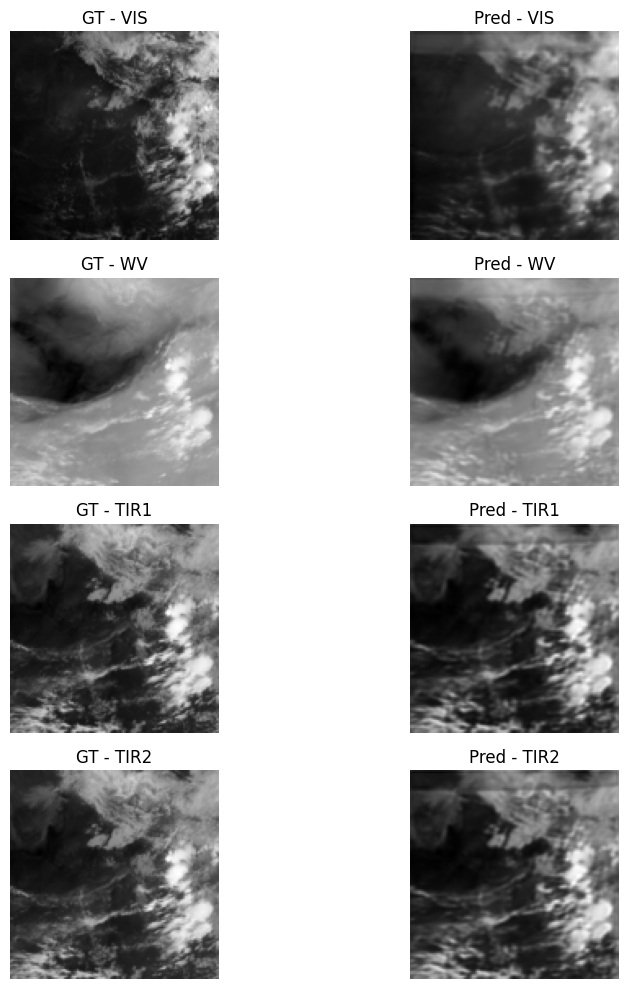

In [ ]:
import matplotlib.pyplot as plt

# Pick a sample from your dataset
test_input, test_target = dataset[0]  # You can change the index to see different examples

# Move to device
test_input = test_input.unsqueeze(0).to(device)  # Add batch dimension: (1, 3, 4, 128, 128)

# Flatten time for model input
input_flat = test_input.view(1, -1, 128, 128)  # Shape: (1, 12, 128, 128)

# Run inference
model.eval()
with torch.no_grad():
    predicted = model(input_flat)  # (1, 4, 128, 128)

# Move to CPU and convert to numpy
predicted = predicted.squeeze(0).cpu().numpy()  # (4, 128, 128)
target = test_target.squeeze(0).numpy()         # (4, 128, 128)

# Plot predictions vs ground truth
fig, axs = plt.subplots(4, 2, figsize=(10, 10))

channel_names = ['VIS', 'WV', 'TIR1', 'TIR2']

for i in range(4):
    axs[i, 0].imshow(target[i], cmap='gray')
    axs[i, 0].set_title(f"GT - {channel_names[i]}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(predicted[i], cmap='gray')
    axs[i, 1].set_title(f"Pred - {channel_names[i]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torch.nn.functional as F

# Convert NumPy arrays to torch tensors
pred_tensor = torch.tensor(predicted, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.float32)

# Calculate MSE
mse = F.mse_loss(pred_tensor, target_tensor)
print(f"\n📏 MSE for sample 0: {mse.item():.6f}")



📏 MSE for sample 0: 0.002569


In [ ]:
from PIL import Image

img = Image.open("/content/drive/MyDrive/upload/VIS/3RIMG_12JUN2025_2045_L1C_SGP_V01R00_IMG_VIS.tif")  # or .jpg, .png, etc.
width, height = img.size

print(f"Width: {width}, Height: {height}")


Width: 1110, Height: 1003


In [ ]:
!pip install scikit-image


In [ ]:
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch.nn.functional as F


In [ ]:
def compute_mae(pred, target):
    return torch.mean(torch.abs(pred - target)).item()


In [ ]:
def compute_psnr(pred, target):
    pred_np = pred.detach().cpu().numpy()
    target_np = target.detach().cpu().numpy()
    scores = []
    for i in range(pred_np.shape[0]):  # batch
        sample_score = 0
        for ch in range(pred_np.shape[1]):  # channel
            sample_score += psnr(target_np[i, ch], pred_np[i, ch], data_range=1.0)
        scores.append(sample_score / pred_np.shape[1])
    return np.mean(scores)


In [ ]:
def compute_ssim(pred, target):
    pred_np = pred.detach().cpu().numpy()
    target_np = target.detach().cpu().numpy()
    scores = []
    for i in range(pred_np.shape[0]):
        sample_score = 0
        for ch in range(pred_np.shape[1]):
            sample_score += ssim(target_np[i, ch], pred_np[i, ch], data_range=1.0)
        scores.append(sample_score / pred_np.shape[1])
    return np.mean(scores)


In [ ]:
model.eval()
with torch.no_grad():
    for inputs, targets in train_loader:  # or use test_loader
        inputs, targets = inputs.to(device), targets.to(device)
        inputs_flat = inputs.view(inputs.size(0), -1, 128, 128)
        targets_flat = targets.view(targets.size(0), -1, 128, 128)

        outputs = model(inputs_flat)

        mae_score = compute_mae(outputs, targets_flat)
        psnr_score = compute_psnr(outputs, targets_flat)
        ssim_score = compute_ssim(outputs, targets_flat)

        print(f"MAE: {mae_score:.4f}, PSNR: {psnr_score:.2f}, SSIM: {ssim_score:.4f}")
        break  # Remove this to run on the full test set


MAE: 0.0291, PSNR: 29.05, SSIM: 0.8998
